In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

pd.set_option('display.max_columns', None)

%load_ext rpy2.ipython

In [2]:
%%R
library(GSA)
library(msigdbr)
library(fgsea)
library(tidyverse) # includes ggplot2, for data visualisation. dplyr, for data manipulation.
library(RColorBrewer) # for a colourful plot

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
%%R

set.seed(42)

# Figure out how to set up gene lists

In [4]:
%%R

all_gene_sets = msigdbr(species = "Mus musculus")
head(all_gene_sets)

# A tibble: 6 × 18
  gs_cat gs_subcat      gs_name        gene_symbol entrez_gene ensembl_gene     
  <chr>  <chr>          <chr>          <chr>             <int> <chr>            
1 C3     MIR:MIR_Legacy AAACCAC_MIR140 Abcc4            239273 ENSMUSG000000328…
2 C3     MIR:MIR_Legacy AAACCAC_MIR140 Abraxas2         109359 ENSMUSG000000309…
3 C3     MIR:MIR_Legacy AAACCAC_MIR140 Actn4             60595 ENSMUSG000000548…
4 C3     MIR:MIR_Legacy AAACCAC_MIR140 Acvr1             11477 ENSMUSG000000268…
5 C3     MIR:MIR_Legacy AAACCAC_MIR140 Adam9             11502 ENSMUSG000000315…
6 C3     MIR:MIR_Legacy AAACCAC_MIR140 Adamts5           23794 ENSMUSG000000228…
# ℹ 12 more variables: human_gene_symbol <chr>, human_entrez_gene <int>,
#   human_ensembl_gene <chr>, gs_id <chr>, gs_pmid <chr>, gs_geoid <chr>,
#   gs_exact_source <chr>, gs_url <chr>, gs_description <chr>, taxon_id <int>,
#   ortholog_sources <chr>, num_ortholog_sources <dbl>


In [5]:
%%R

# Get the MSigDB collections
collections <- msigdbr_collections()

# Print all rows of the tibble
print(collections, n = Inf)

# A tibble: 23 × 3
   gs_cat gs_subcat         num_genesets
   <chr>  <chr>                    <int>
 1 C1     ""                         299
 2 C2     "CGP"                     3384
 3 C2     "CP"                        29
 4 C2     "CP:BIOCARTA"              292
 5 C2     "CP:KEGG"                  186
 6 C2     "CP:PID"                   196
 7 C2     "CP:REACTOME"             1615
 8 C2     "CP:WIKIPATHWAYS"          664
 9 C3     "MIR:MIRDB"               2377
10 C3     "MIR:MIR_Legacy"           221
11 C3     "TFT:GTRD"                 518
12 C3     "TFT:TFT_Legacy"           610
13 C4     "CGN"                      427
14 C4     "CM"                       431
15 C5     "GO:BP"                   7658
16 C5     "GO:CC"                   1006
17 C5     "GO:MF"                   1738
18 C5     "HPO"                     5071
19 C6     ""                         189
20 C7     "IMMUNESIGDB"             4872
21 C7     "VAX"                      347
22 C8     ""                         7

In [6]:
%%R

#Retrieve human H (hallmark gene sets) 
msigdbr_df <- msigdbr(species = "mouse", category = "H")


head(msigdbr_df)

# A tibble: 6 × 18
  gs_cat gs_subcat gs_name               gene_symbol entrez_gene ensembl_gene   
  <chr>  <chr>     <chr>                 <chr>             <int> <chr>          
1 H      ""        HALLMARK_ADIPOGENESIS Abca1             11303 ENSMUSG0000001…
2 H      ""        HALLMARK_ADIPOGENESIS Abcb8             74610 ENSMUSG0000002…
3 H      ""        HALLMARK_ADIPOGENESIS Acaa2             52538 ENSMUSG0000003…
4 H      ""        HALLMARK_ADIPOGENESIS Acadl             11363 ENSMUSG0000002…
5 H      ""        HALLMARK_ADIPOGENESIS Acadm             11364 ENSMUSG0000006…
6 H      ""        HALLMARK_ADIPOGENESIS Acads             11409 ENSMUSG0000002…
# ℹ 12 more variables: human_gene_symbol <chr>, human_entrez_gene <int>,
#   human_ensembl_gene <chr>, gs_id <chr>, gs_pmid <chr>, gs_geoid <chr>,
#   gs_exact_source <chr>, gs_url <chr>, gs_description <chr>, taxon_id <int>,
#   ortholog_sources <chr>, num_ortholog_sources <dbl>


In [7]:
%%R

pathwaysH = split(x = msigdbr_df$gene_symbol, f = msigdbr_df$gs_name)
head(pathwaysH)

$HALLMARK_ADIPOGENESIS
  [1] "Abca1"    "Abcb8"    "Acaa2"    "Acadl"    "Acadm"    "Acads"   
  [7] "Acly"     "Aco2"     "Acox1"    "Adcy6"    "Adig"     "Adipoq"  
 [13] "Adipor2"  "Agpat3"   "Aifm1"    "Ak2"      "Aldh2"    "Aldoa"   
 [19] "Angpt1"   "Angptl4"  "Aplp2"    "Apoe"     "Araf"     "Arl4a"   
 [25] "Atl2"     "Atp1b3"   "Atp5o"    "Baz2a"    "Bckdha"   "Bcl2l13" 
 [31] "Bcl6"     "C3"       "Cat"      "Cavin1"   "Cavin2"   "Ccng2"   
 [37] "Cd151"    "Cd302"    "Cd36"     "Cdkn2c"   "Chchd10"  "Chuk"    
 [43] "Cidea"    "Cmbl"     "Cmpk1"    "Col15a1"  "Col4a1"   "Coq3"    
 [49] "Coq5"     "Coq9"     "Cox6a1"   "Cox7b"    "Cox8a"    "Cpt2"    
 [55] "Crat"     "Cs"       "Cyc1"     "Cyp4b1"   "Dbt"      "Ddt"     
 [61] "Decr1"    "Dgat1"    "Dhcr7"    "Dhrs7"    "Dhrs7b"   "Dlat"    
 [67] "Dld"      "Dnajb9"   "Dnajc15"  "Dram2"    "Ech1"     "Echs1"   
 [73] "Elmod3"   "Elovl6"   "Enpp2"    "Ephx2"    "Esrra"    "Esyt1"   
 [79] "Etfb"     "Fabp4"    "Fah"      "F

In [8]:
%%R

options(ports=8888)

# LPC_demyel_OPCs:

In [9]:
%%R

# Replace the file path with the actual path if the file is not in the current directory
df <- read.csv("./files/LPC_demyel_OPCs_voom_wqw_REDO.csv")
head(df)  # Display the first few rows of the data frame to confirm it's loaded correctly

       gene     logFC  AveExpr         t      P.Value    adj.P.Val        B
1       C4b  4.969368 5.166741  17.92496 1.262250e-11 1.019015e-07 15.94549
2 Serpina3n  5.016019 5.574485  16.22826 5.319566e-11 1.760439e-07 15.14196
3    Dbndd2  4.443583 4.783055  15.99661 6.541952e-11 1.760439e-07 14.73933
4   Col16a1  2.322603 5.886618  15.56691 9.670652e-11 1.951779e-07 14.77328
5    Unc13c -2.726557 6.612704 -13.55744 6.896989e-10 9.751585e-07 12.69665
6     Josd2  3.069189 4.524543  13.50979 7.247555e-10 9.751585e-07 12.74182


In [10]:
%%R

dim(df)

[1] 8073    7


In [11]:
%%R

my_genes <- df$gene
head(my_genes)

[1] "C4b"       "Serpina3n" "Dbndd2"    "Col16a1"   "Unc13c"    "Josd2"    


In [12]:
%%R
# Check column names in the dataframe
colnames(df)

[1] "gene"      "logFC"     "AveExpr"   "t"         "P.Value"   "adj.P.Val"
[7] "B"        


In [47]:
%%R

# Filter the dataset for significant genes
filtered_df <- df[abs(df$logFC) >= 0.585 & df$adj.P.Val < 0.05, ]

# Compute ranking score: sign(logFC) * -log10(P.Value)
filtered_df$ranking_score <- sign(filtered_df$logFC) * -log10(filtered_df$P.Value)

# Assign names to the rankings
rankings <- filtered_df$ranking_score
names(rankings) <- filtered_df$gene

# Sort the rankings in descending order
rankings <- sort(rankings, decreasing = TRUE)

In [ ]:
%%R

# Assign names to the rankings
#rankings <- df$logFC
#names(rankings) <- df$gene

# Sort the rankings
#rankings <- sort(rankings, decreasing = TRUE)

In [48]:
%%R

length(rankings)

[1] 1565


In [49]:
%%R

# Ensure the length of the gene column matches the length of rankings
length(df$gene) == length(rankings)

[1] FALSE


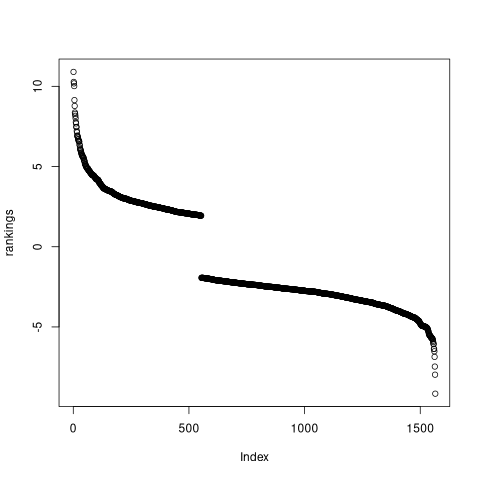

In [50]:
%%R

plot(rankings)

In [51]:
%%R

max(rankings)

[1] 10.89885


In [52]:
%%R

min(rankings)

[1] -9.16134


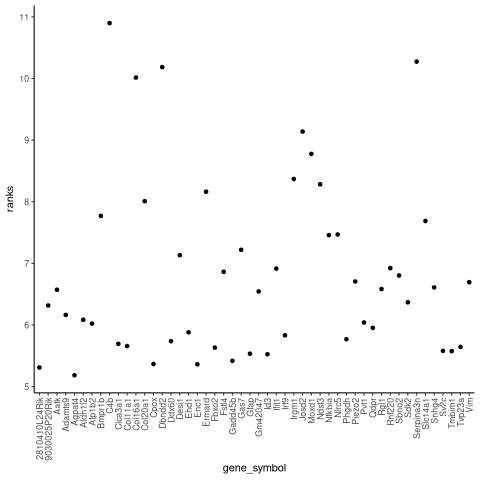

In [53]:
%%R

ggplot(data.frame(gene_symbol = names(rankings)[1:50], ranks = rankings[1:50]), aes(gene_symbol, ranks)) + 
    geom_point() +
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [54]:
%%R

head(rankings)

      C4b Serpina3n    Dbndd2   Col16a1     Josd2     Moxd1 
10.898855 10.274124 10.184293 10.014544  9.139808  8.776385 


# START OPC GSEA

In [55]:
%%R
fgsea_OPC <- fgsea(pathways = pathwaysH, 
                  stats    = rankings,
                  scoreType = 'std',
                  minSize  = 15,
                  maxSize  = 500)

In [56]:
%%R
fgsea_OPC

                                       pathway         pval         padj
                                        <char>        <num>        <num>
 1:               HALLMARK_ALLOGRAFT_REJECTION 2.261119e-02 6.166688e-02
 2:                 HALLMARK_ANDROGEN_RESPONSE 5.978836e-01 6.513092e-01
 3:                   HALLMARK_APICAL_JUNCTION 4.158879e-01 5.671198e-01
 4:                         HALLMARK_APOPTOSIS 1.203902e-04 9.029262e-04
 5:           HALLMARK_CHOLESTEROL_HOMEOSTASIS 5.240642e-01 6.513092e-01
 6:                        HALLMARK_COMPLEMENT 6.078886e-01 6.513092e-01
 7:                        HALLMARK_DNA_REPAIR 1.385056e-02 4.616852e-02
 8:                       HALLMARK_E2F_TARGETS 6.370238e-05 6.370238e-04
 9: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 5.520797e-02 1.380199e-01
10:           HALLMARK_ESTROGEN_RESPONSE_EARLY 3.964602e-01 5.671198e-01
11:            HALLMARK_ESTROGEN_RESPONSE_LATE 2.111369e-01 4.524362e-01
12:             HALLMARK_FATTY_ACID_METABOLISM 5.92

In [57]:
%%R

dim(fgsea_OPC)

[1] 30  8


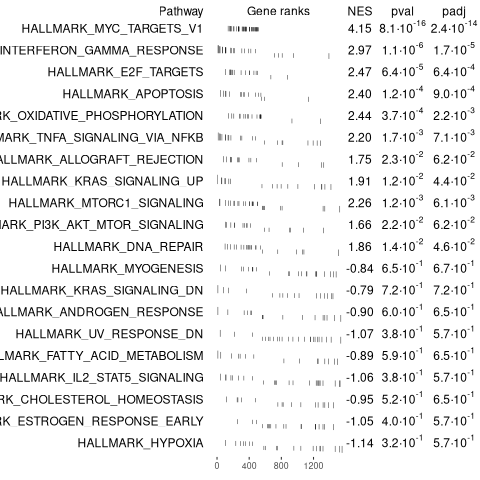

In [58]:
%%R

topUp <- fgsea_OPC %>% 
    filter(ES > 0) %>% 
    top_n(10, wt=-padj)
topDown <- fgsea_OPC %>% 
    filter(ES < 0) %>% 
    top_n(10, wt=-padj)
topPathways <- bind_rows(topUp, topDown) %>% 
    arrange(-ES)
plotGseaTable(pathwaysH[topPathways$pathway], 
              rankings, 
              fgsea_OPC, 
              gseaParam = 0.5)

In [59]:
%%R

# Filter for significant results with padj < 0.05
fgsea_OPC_significant <- fgsea_OPC %>% filter(padj < 0.1)
dim(fgsea_OPC_significant)

[1] 11  8


In [60]:
%%R

head(fgsea_OPC_significant)

                              pathway         pval         padj   log2err
                               <char>        <num>        <num>     <num>
1:       HALLMARK_ALLOGRAFT_REJECTION 2.261119e-02 6.166688e-02 0.3524879
2:                 HALLMARK_APOPTOSIS 1.203902e-04 9.029262e-04 0.5384341
3:                HALLMARK_DNA_REPAIR 1.385056e-02 4.616852e-02 0.3807304
4:               HALLMARK_E2F_TARGETS 6.370238e-05 6.370238e-04 0.5384341
5: HALLMARK_INTERFERON_GAMMA_RESPONSE 1.122475e-06 1.683712e-05 0.6435518
6:         HALLMARK_KRAS_SIGNALING_UP 1.183037e-02 4.436387e-02 0.3807304
          ES      NES  size
       <num>    <num> <int>
1: 0.4221450 1.745669    15
2: 0.5629605 2.404874    16
3: 0.3842292 1.862395    22
4: 0.5780295 2.469246    16
5: 0.5870034 2.972368    24
6: 0.4212618 1.905040    18
                                            leadingEdge
                                                 <list>
1:                Tgfb2,Apbb1,Nme1,Csf1,Stat1,Eif5a,...
2:             G

In [61]:
%%R
library(data.table)

fwrite(fgsea_OPC, file = "./files/fgsea_LPC_demyel_OPC_all.csv")

# Explore specific gene lists?

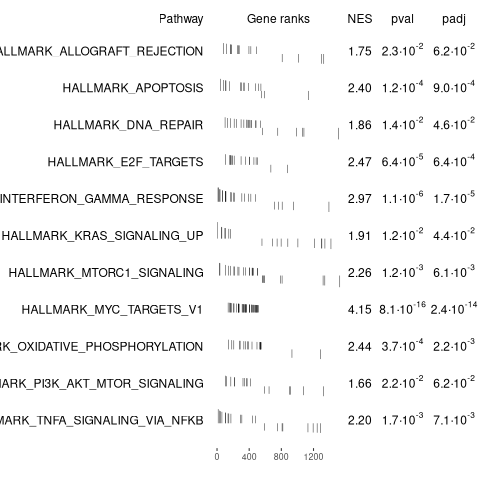

In [62]:
%%R

plotGseaTable(pathwaysH[fgsea_OPC_significant$pathway], 
              rankings, 
              fgsea_OPC_significant, 
              gseaParam = 0.5)

In [63]:
%%R

collapsedPathways <- collapsePathways(fgsea_OPC_significant[order(pval)][padj < 0.01], 
                                      pathwaysH, rankings)

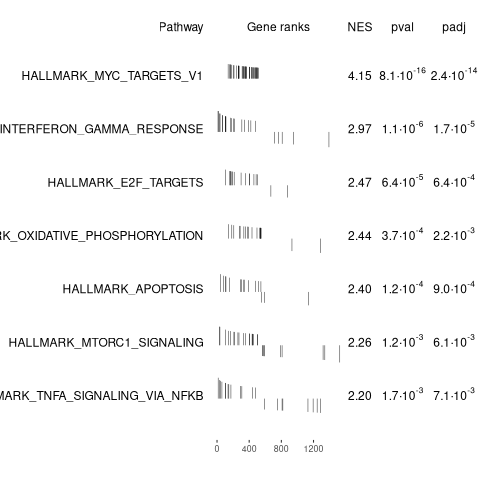

In [64]:
%%R

mainPathways <- fgsea_OPC_significant[pathway %in% collapsedPathways$mainPathways][
                         order(-NES), pathway]
plotGseaTable(pathwaysH[mainPathways], rankings, fgsea_OPC_significant, 
              gseaParam = 0.5)

In [65]:
%%R

fgseaResTidy <- fgsea_OPC %>%
  as_tibble() %>%
  arrange(desc(NES))

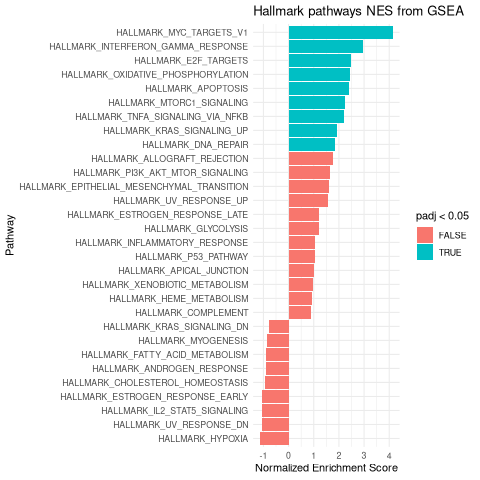

In [66]:
%%R

ggplot(fgseaResTidy, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.05)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score",
       title="Hallmark pathways NES from GSEA") + 
  theme_minimal()


#https://stephenturner.github.io/deseq-to-fgsea/#using_the_fgsea_package

In [67]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.05, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 6 × 4
  pathway                                padj   NES  size
  <chr>                                 <dbl> <dbl> <int>
1 HALLMARK_MYC_TARGETS_V1            2.42e-14  4.15    40
2 HALLMARK_INTERFERON_GAMMA_RESPONSE 1.68e- 5  2.97    24
3 HALLMARK_E2F_TARGETS               6.37e- 4  2.47    16
4 HALLMARK_APOPTOSIS                 9.03e- 4  2.40    16
5 HALLMARK_OXIDATIVE_PHOSPHORYLATION 2.22e- 3  2.44    19
6 HALLMARK_MTORC1_SIGNALING          6.14e- 3  2.26    28


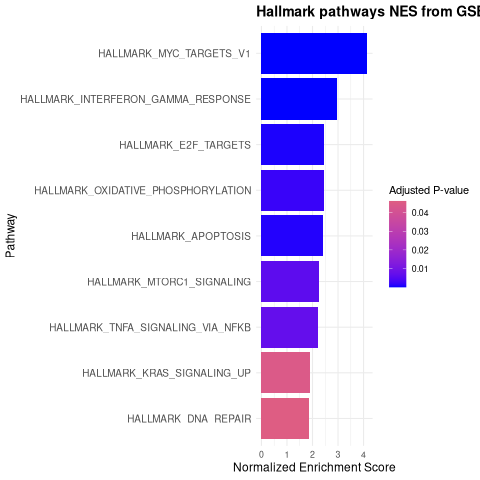

In [68]:
%%R

# Create the ggplot with a color scale for padj
ggplot(fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

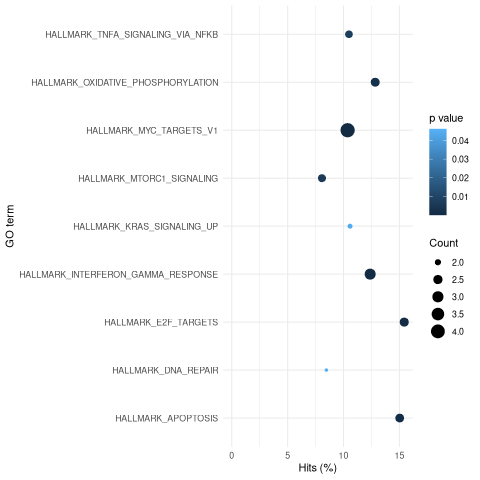

In [69]:
%%R

# Calculate hits percentage (if 'numDEInCat' and 'numInCat' equivalent are 'NES' and 'size')
fgseaResSignificant <- fgseaResSignificant %>%
  mutate(hitsPerc = NES * 100 / size)

# Ensure the columns 'padj' and 'NES' are present for the plot
fgseaResSignificant <- fgseaResSignificant %>%
  rename(term = pathway, over_represented_pvalue = padj, numDEInCat = NES)

# Create the plot
ggplot(fgseaResSignificant, aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
  geom_point() +
  expand_limits(x = 0) +
  labs(x = "Hits (%)", y = "GO term", colour = "p value", size = "Count") +
  theme_minimal()

#https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2018/RNASeq2018/html/06_Gene_set_testing.nb.html

In [70]:
%%R

fgsea_OPC_significant

Index: <pathway>
                               pathway         pval         padj   log2err
                                <char>        <num>        <num>     <num>
 1:       HALLMARK_ALLOGRAFT_REJECTION 2.261119e-02 6.166688e-02 0.3524879
 2:                 HALLMARK_APOPTOSIS 1.203902e-04 9.029262e-04 0.5384341
 3:                HALLMARK_DNA_REPAIR 1.385056e-02 4.616852e-02 0.3807304
 4:               HALLMARK_E2F_TARGETS 6.370238e-05 6.370238e-04 0.5384341
 5: HALLMARK_INTERFERON_GAMMA_RESPONSE 1.122475e-06 1.683712e-05 0.6435518
 6:         HALLMARK_KRAS_SIGNALING_UP 1.183037e-02 4.436387e-02 0.3807304
 7:          HALLMARK_MTORC1_SIGNALING 1.227481e-03 6.137404e-03 0.4550599
 8:            HALLMARK_MYC_TARGETS_V1 8.078946e-16 2.423684e-14 1.0276699
 9: HALLMARK_OXIDATIVE_PHOSPHORYLATION 3.695211e-04 2.217127e-03 0.4984931
10:   HALLMARK_PI3K_AKT_MTOR_SIGNALING 2.154219e-02 6.166688e-02 0.3524879
11:   HALLMARK_TNFA_SIGNALING_VIA_NFKB 1.660099e-03 7.114710e-03 0.4550599
        

In [71]:
%%R

collapsedPathways <- collapsePathways(fgsea_OPC_significant[order(pval)][padj < 0.05], 
                                      pathwaysH, rankings)

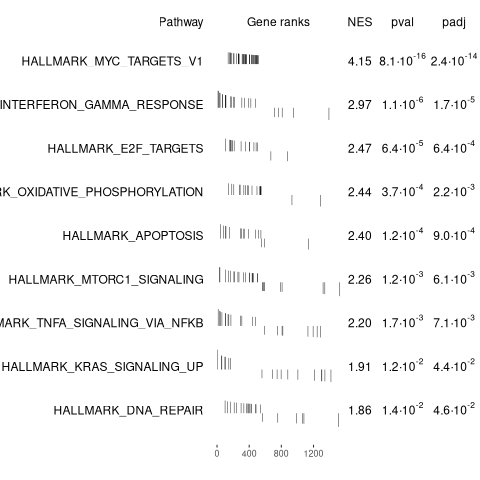

In [72]:
%%R

mainPathways <- fgsea_OPC_significant[pathway %in% collapsedPathways$mainPathways][
                         order(-NES), pathway]
plotGseaTable(pathwaysH[mainPathways], rankings, fgsea_OPC_significant, 
              gseaParam = 0.5)

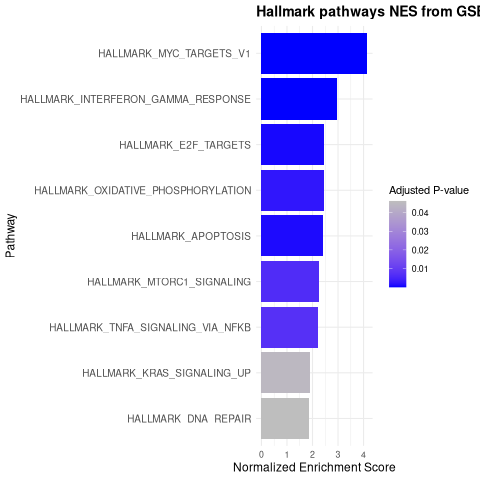

In [73]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgsea_OPC_significant <- fgsea_OPC_significant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Create the ggplot with a color scale for padj
ggplot(filtered_fgsea_OPC_significant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "blue", high = "grey", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )


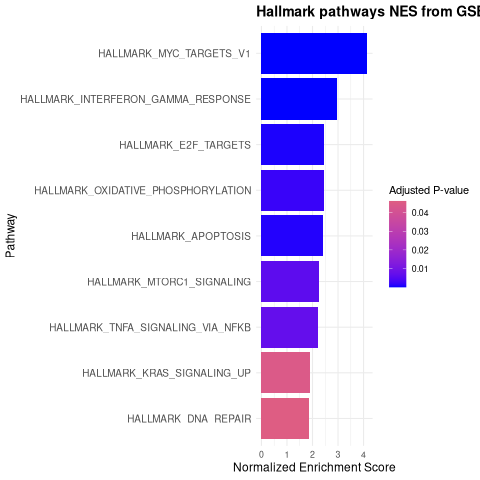

In [74]:
%%R

# Create the ggplot with a color scale for padj
ggplot(filtered_fgsea_OPC_significant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

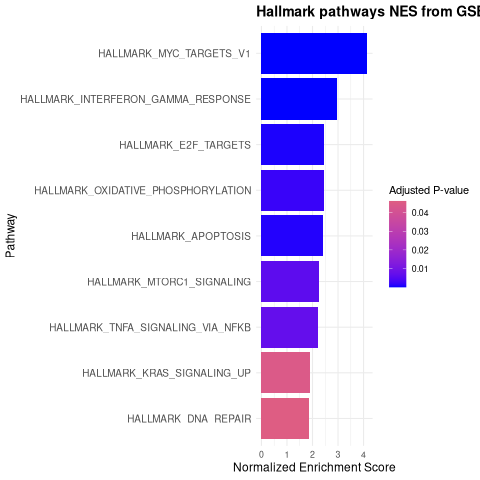

In [75]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgsea_OPC_significant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

# Save the plot as a high-resolution PNG file
#ggsave("./figures/GSEA/LPC_demyel_OPC_hallmark_pathways_NES_GSEA.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

In [76]:
%%R
head(filtered_fgsea_OPC_significant)

                              pathway         pval         padj   log2err
                               <char>        <num>        <num>     <num>
1:                 HALLMARK_APOPTOSIS 1.203902e-04 9.029262e-04 0.5384341
2:                HALLMARK_DNA_REPAIR 1.385056e-02 4.616852e-02 0.3807304
3:               HALLMARK_E2F_TARGETS 6.370238e-05 6.370238e-04 0.5384341
4: HALLMARK_INTERFERON_GAMMA_RESPONSE 1.122475e-06 1.683712e-05 0.6435518
5:         HALLMARK_KRAS_SIGNALING_UP 1.183037e-02 4.436387e-02 0.3807304
6:          HALLMARK_MTORC1_SIGNALING 1.227481e-03 6.137404e-03 0.4550599
          ES      NES  size
       <num>    <num> <int>
1: 0.5629605 2.404874    16
2: 0.3842292 1.862395    22
3: 0.5780295 2.469246    16
4: 0.5870034 2.972368    24
5: 0.4212618 1.905040    18
6: 0.4209841 2.259673    28
                                            leadingEdge
                                                 <list>
1:             Gadd45b,Tgfb2,Cdkn1a,Casp3,Lmna,Ier3,...
2:              

In [77]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
filtered_fgsea_OPC_significant$pathway <- gsub("^HALLMARK_", "", filtered_fgsea_OPC_significant$pathway)

# View the updated heatmap_df
head(filtered_fgsea_OPC_significant)

                     pathway         pval         padj   log2err        ES
                      <char>        <num>        <num>     <num>     <num>
1:                 APOPTOSIS 1.203902e-04 9.029262e-04 0.5384341 0.5629605
2:                DNA_REPAIR 1.385056e-02 4.616852e-02 0.3807304 0.3842292
3:               E2F_TARGETS 6.370238e-05 6.370238e-04 0.5384341 0.5780295
4: INTERFERON_GAMMA_RESPONSE 1.122475e-06 1.683712e-05 0.6435518 0.5870034
5:         KRAS_SIGNALING_UP 1.183037e-02 4.436387e-02 0.3807304 0.4212618
6:          MTORC1_SIGNALING 1.227481e-03 6.137404e-03 0.4550599 0.4209841
        NES  size                                          leadingEdge
      <num> <int>                                               <list>
1: 2.404874    16             Gadd45b,Tgfb2,Cdkn1a,Casp3,Lmna,Ier3,...
2: 1.862395    22                   Taf10,Ak3,Nme1,Trp53,Guk1,Rpa2,...
3: 2.469246    16                Cdkn1a,Mms22l,Nme1,Cdk4,Stmn1,Ak2,...
4: 2.972368    24              Nlrc5,Nfkbia,I

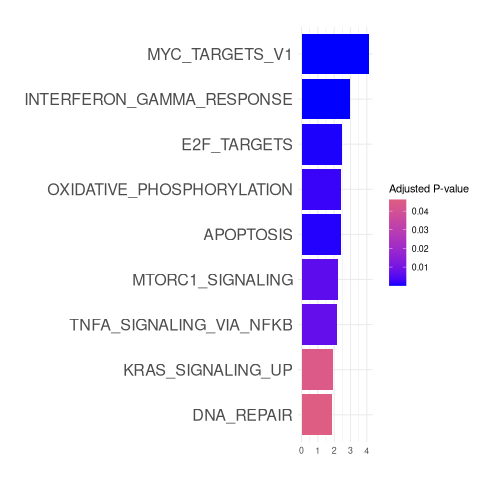

In [78]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgsea_OPC_significant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "", y = "",
       title = "") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 16),
    axis.title = element_text(size = 16),
    plot.title = element_text(size = 16, face = "bold")
  )

# Save the plot as a high-resolution PNG file
ggsave("./figures/GSEA/LPC_demyel_OPC_hallmark_pathways_barchart_logFC_cutoff_rank_signPvalue.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

In [79]:
%%R

head(filtered_fgsea_OPC_significant)

                     pathway         pval         padj   log2err        ES
                      <char>        <num>        <num>     <num>     <num>
1:                 APOPTOSIS 1.203902e-04 9.029262e-04 0.5384341 0.5629605
2:                DNA_REPAIR 1.385056e-02 4.616852e-02 0.3807304 0.3842292
3:               E2F_TARGETS 6.370238e-05 6.370238e-04 0.5384341 0.5780295
4: INTERFERON_GAMMA_RESPONSE 1.122475e-06 1.683712e-05 0.6435518 0.5870034
5:         KRAS_SIGNALING_UP 1.183037e-02 4.436387e-02 0.3807304 0.4212618
6:          MTORC1_SIGNALING 1.227481e-03 6.137404e-03 0.4550599 0.4209841
        NES  size                                          leadingEdge
      <num> <int>                                               <list>
1: 2.404874    16             Gadd45b,Tgfb2,Cdkn1a,Casp3,Lmna,Ier3,...
2: 1.862395    22                   Taf10,Ak3,Nme1,Trp53,Guk1,Rpa2,...
3: 2.469246    16                Cdkn1a,Mms22l,Nme1,Cdk4,Stmn1,Ak2,...
4: 2.972368    24              Nlrc5,Nfkbia,I

In [80]:
%%R
unique(filtered_fgsea_OPC_significant$pathway)

[1] "APOPTOSIS"                 "DNA_REPAIR"               
[3] "E2F_TARGETS"               "INTERFERON_GAMMA_RESPONSE"
[5] "KRAS_SIGNALING_UP"         "MTORC1_SIGNALING"         
[7] "MYC_TARGETS_V1"            "OXIDATIVE_PHOSPHORYLATION"
[9] "TNFA_SIGNALING_VIA_NFKB"  


In [81]:
%%R

# Define the pathway of interest
pathway_of_interest <- "TNFA_SIGNALING_VIA_NFKB"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgsea_OPC_significant[filtered_fgsea_OPC_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

[1] "Nfkbia"  "Ehd1"    "Gadd45b" "Cebpd"   "Cdkn1a"  "Panx1"   "Relb"   
[8] "Trib1"   "Csf1"   


In [82]:
%%R

# Define the pathway of interest
pathway_of_interest <- "CHOLESTEROL_HOMEOSTASIS"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgsea_OPC_significant[filtered_fgsea_OPC_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [83]:
%%R

# Define the pathway of interest
pathway_of_interest <- "ESTROGEN_RESPONSE_EARLY"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgsea_OPC_significant[filtered_fgsea_OPC_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [84]:
%%R

# Define the pathway of interest
pathway_of_interest <- "INTERFERON_GAMMA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgsea_OPC_significant[filtered_fgsea_OPC_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Nlrc5"   "Nfkbia"  "Irf9"    "Ddx60"   "Rnf213"  "Lap3"    "Cdkn1a" 
 [8] "Eif2ak2" "Herc6"   "Casp3"   "Bpgm"    "Stat1"   "Ifi27"   "Stat2"  


In [85]:
%%R

# Define the pathway of interest
pathway_of_interest <- "INTERFERON_ALPHA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgsea_OPC_significant[filtered_fgsea_OPC_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [86]:
%%R

class(filtered_fgsea_OPC_significant)

[1] "data.table" "data.frame"


In [87]:
%%R

filtered_fgsea_OPC_significant <- as.data.frame(filtered_fgsea_OPC_significant)

In [88]:
%%R
library(data.table)
fwrite(filtered_fgsea_OPC_significant, file = "./files/filtered_fgseaResSignificant_LPC_demyel_OPC_NEW.csv")

In [89]:
%%R

# Load the data.table package
library(data.table)

# Read the saved CSV file back into R
filtered_fgsea_OPC_significant <- fread("./files/filtered_fgseaResSignificant_LPC_demyel_OPC_NEW.csv")

# Check the first few rows to confirm successful loading
head(filtered_fgsea_OPC_significant)

                     pathway         pval         padj   log2err        ES
                      <char>        <num>        <num>     <num>     <num>
1:                 APOPTOSIS 1.203902e-04 9.029262e-04 0.5384341 0.5629605
2:                DNA_REPAIR 1.385056e-02 4.616852e-02 0.3807304 0.3842292
3:               E2F_TARGETS 6.370238e-05 6.370238e-04 0.5384341 0.5780295
4: INTERFERON_GAMMA_RESPONSE 1.122475e-06 1.683712e-05 0.6435518 0.5870034
5:         KRAS_SIGNALING_UP 1.183037e-02 4.436387e-02 0.3807304 0.4212618
6:          MTORC1_SIGNALING 1.227481e-03 6.137404e-03 0.4550599 0.4209841
        NES  size
      <num> <int>
1: 2.404874    16
2: 1.862395    22
3: 2.469246    16
4: 2.972368    24
5: 1.905040    18
6: 2.259673    28
                                                                                                                                leadingEdge
                                                                                                                    

In [90]:
%%R

unique_pathways <- unique(filtered_fgsea_OPC_significant$pathway)
print(unique_pathways)

[1] "APOPTOSIS"                 "DNA_REPAIR"               
[3] "E2F_TARGETS"               "INTERFERON_GAMMA_RESPONSE"
[5] "KRAS_SIGNALING_UP"         "MTORC1_SIGNALING"         
[7] "MYC_TARGETS_V1"            "OXIDATIVE_PHOSPHORYLATION"
[9] "TNFA_SIGNALING_VIA_NFKB"  


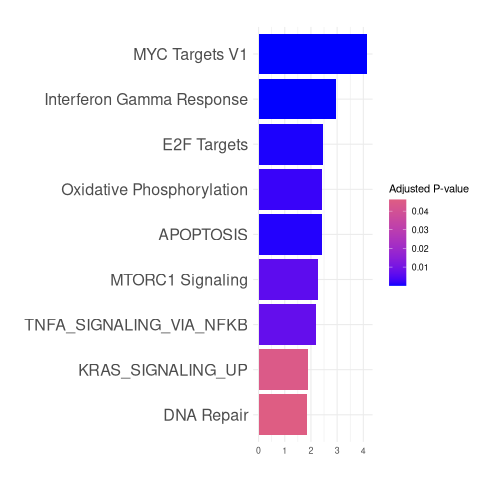

In [91]:
%%R

# Define the dictionary to rename the pathways
pathway_rename_dict <- c(
  "BILE_ACID_METABOLISM" = "Bile Acid Metabolism",
  "CHOLESTEROL_HOMEOSTASIS" = "Cholesterol Homeostasis",
  "DNA_REPAIR" = "DNA Repair",
  "E2F_TARGETS" = "E2F Targets",
  "ESTROGEN_RESPONSE_EARLY" = "Estrogen Response Early",
  "FATTY_ACID_METABOLISM" = "Fatty Acid Metabolism",
  "HEDGEHOG_SIGNALING" = "Hedgehog Signaling",
  "INTERFERON_GAMMA_RESPONSE" = "Interferon Gamma Response",
  "MTORC1_SIGNALING" = "MTORC1 Signaling",
  "MYC_TARGETS_V1" = "MYC Targets V1",
  "MYC_TARGETS_V2" = "MYC Targets V2",
  "OXIDATIVE_PHOSPHORYLATION" = "Oxidative Phosphorylation",
  "REACTIVE_OXYGEN_SPECIES_PATHWAY" = "Reactive Oxygen Species Pathway",
  "UNFOLDED_PROTEIN_RESPONSE" = "Unfolded Protein Response",
  "UV_RESPONSE_DN" = "UV Response Down"
)

# Apply the renaming to the 'pathway' column
filtered_fgsea_OPC_significant$pathway <- recode(filtered_fgsea_OPC_significant$pathway, !!!pathway_rename_dict)

# Create the ggplot
plot <- ggplot(filtered_fgsea_OPC_significant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "", y = "",
       title = "") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 16),
    axis.title = element_text(size = 16),
    plot.title = element_text(size = 16, face = "bold")
  )

# Save the plot as a high-resolution PNG file
ggsave("./figures/GSEA/LPC_demyel_OPC_hallmark_pathways_NES_GSEA_trimmed.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

# LPC_demyel_MOL_F

In [92]:
%%R

# Replace the file path with the actual path if the file is not in the current directory
df <- read.csv("./files/LPC_demyel_MOL_DvF_voom_wqw_NEW.csv")
head(df)  # Display the first few rows of the data frame to confirm it's loaded correctly

     logFC  AveExpr        t      P.Value    adj.P.Val        B      gene
1 6.533785 6.775086 28.63736 1.130871e-13 1.094344e-09 21.54591 Serpina3n
2 3.780291 4.164128 24.83927 7.753378e-13 3.162973e-09 19.50304     Pros1
3 3.733416 6.483897 24.41059 9.805640e-13 3.162973e-09 19.51768    Fam13c
4 2.665567 8.585220 19.61067 1.848409e-11 4.471764e-08 16.73227      Il33
5 5.584361 4.426395 18.22433 4.899760e-11 9.482996e-08 15.72774  Slc9a3r2
6 3.211838 7.230794 17.93574 6.054159e-11 9.764349e-08 15.58027      Gpd1


In [93]:
%%R

dim(df)

[1] 9677    7


In [94]:
%%R

my_genes <- df$gene
head(my_genes)

[1] "Serpina3n" "Pros1"     "Fam13c"    "Il33"      "Slc9a3r2"  "Gpd1"     


In [95]:
%%R
# Check column names in the dataframe
colnames(df)

[1] "logFC"     "AveExpr"   "t"         "P.Value"   "adj.P.Val" "B"        
[7] "gene"     


In [96]:
%%R

# Filter the dataset for significant genes
filtered_df <- df[abs(df$logFC) >= 0.585 & df$adj.P.Val < 0.05, ]

# Compute ranking score: sign(logFC) * -log10(P.Value)
filtered_df$ranking_score <- sign(filtered_df$logFC) * -log10(filtered_df$P.Value)

# Assign names to the rankings
rankings <- filtered_df$ranking_score
names(rankings) <- filtered_df$gene

# Sort the rankings in descending order
rankings <- sort(rankings, decreasing = TRUE)

In [97]:
%%R

# Ensure the length of the gene column matches the length of rankings
length(df$gene) == length(rankings)

[1] FALSE


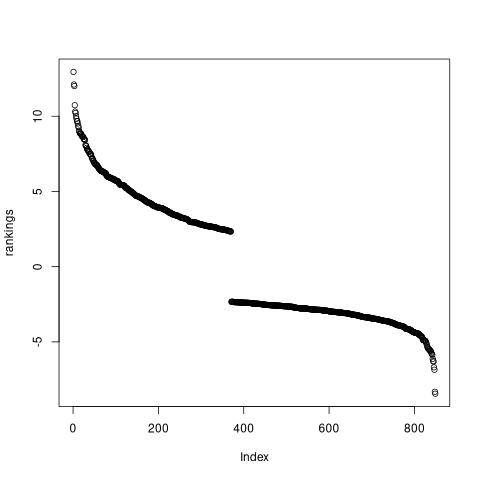

In [98]:
%%R

plot(rankings)

In [99]:
%%R

max(rankings)

[1] 12.94659


In [100]:
%%R

min(rankings)

[1] -8.444849


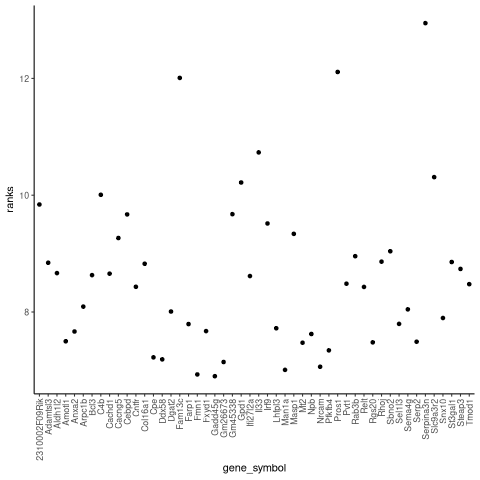

In [101]:
%%R

ggplot(data.frame(gene_symbol = names(rankings)[1:50], ranks = rankings[1:50]), aes(gene_symbol, ranks)) + 
    geom_point() +
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Figure out how to set up gene lists

In [102]:
%%R
fgsea_res <- fgsea(pathways = pathwaysH, 
                  stats    = rankings,
                  scoreType = 'std',
                  minSize  = 15,
                  maxSize  = 500)

In [103]:
%%R
fgsea_res

                               pathway         pval         padj    log2err
                                <char>        <num>        <num>      <num>
 1:           HALLMARK_APICAL_JUNCTION 4.718662e-03 1.415599e-02 0.40701792
 2:   HALLMARK_CHOLESTEROL_HOMEOSTASIS 9.278351e-02 1.855670e-01 0.27650060
 3:   HALLMARK_ESTROGEN_RESPONSE_EARLY 6.013986e-02 1.443357e-01 0.21654284
 4:    HALLMARK_ESTROGEN_RESPONSE_LATE 1.588087e-03 9.528522e-03 0.45505987
 5:            HALLMARK_G2M_CHECKPOINT 6.722925e-01 8.067511e-01 0.04773424
 6: HALLMARK_INTERFERON_GAMMA_RESPONSE 2.211376e-06 2.653652e-05 0.62725674
 7:          HALLMARK_MTORC1_SIGNALING 8.689384e-01 8.689384e-01 0.03257852
 8:                HALLMARK_MYOGENESIS 6.529210e-01 8.067511e-01 0.09435636
 9:               HALLMARK_P53_PATHWAY 5.302391e-01 7.953586e-01 0.05871859
10:   HALLMARK_TNFA_SIGNALING_VIA_NFKB 3.971535e-03 1.415599e-02 0.40701792
11:            HALLMARK_UV_RESPONSE_DN 8.581267e-01 8.689384e-01 0.03554202
12:     HALL

In [104]:
%%R

dim(fgsea_res)

[1] 12  8


In [105]:
%%R

fwrite(fgsea_res, file = "./files/fgsea_LPC_demyel_MOL_F_all.csv")

In [106]:
%%R

# Filter for significant results with padj < 0.05
fgsea_MOL2_significant <- fgsea_res %>% filter(padj < 0.1)
dim(fgsea_MOL2_significant)

[1] 4 8


In [107]:
%%R

head(fgsea_MOL2_significant)

                              pathway         pval         padj   log2err
                               <char>        <num>        <num>     <num>
1:           HALLMARK_APICAL_JUNCTION 4.718662e-03 1.415599e-02 0.4070179
2:    HALLMARK_ESTROGEN_RESPONSE_LATE 1.588087e-03 9.528522e-03 0.4550599
3: HALLMARK_INTERFERON_GAMMA_RESPONSE 2.211376e-06 2.653652e-05 0.6272567
4:   HALLMARK_TNFA_SIGNALING_VIA_NFKB 3.971535e-03 1.415599e-02 0.4070179
          ES      NES  size                                  leadingEdge
       <num>    <num> <int>                                       <list>
1: 0.5268229 1.950714    18 Col16a1,Inppl1,Nlgn2,Tspan4,Ldlrap1,Flnc,...
2: 0.5178293 2.025713    21    Serpina3n,Snx10,Farp1,Cpe,Aldh3b1,Cd9,...
3: 0.6432025 2.532463    22        Irf9,Mt2,Nlrc5,Eif2ak2,Socs3,Rtp4,...
4: 0.4912544 1.921753    21       Cebpd,Bcl3,Socs3,Ehd1,Fjx1,Gadd45b,...


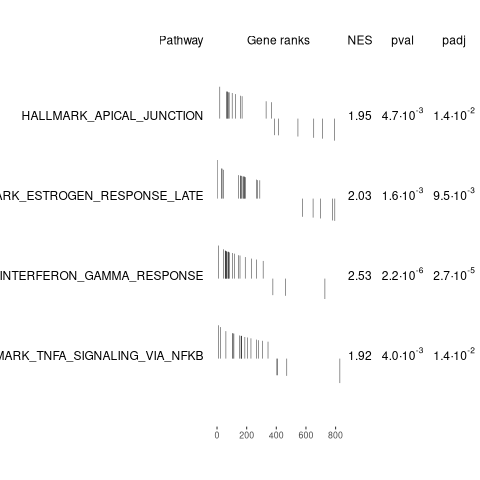

In [108]:
%%R

plotGseaTable(pathwaysH[fgsea_MOL2_significant$pathway], 
              rankings, 
              fgsea_MOL2_significant, 
              gseaParam = 0.5)

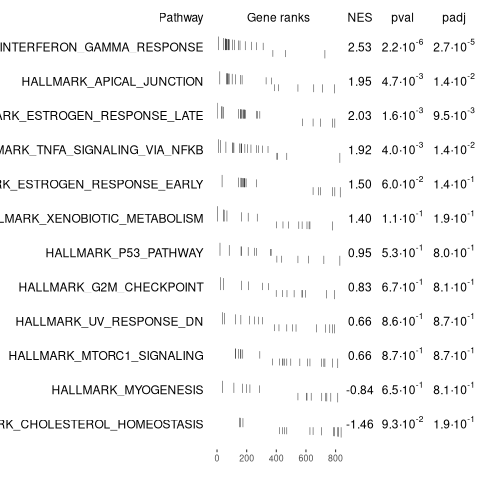

In [109]:
%%R

topUp <- fgsea_res %>% 
    filter(ES > 0) %>% 
    top_n(10, wt=-padj)
topDown <- fgsea_res %>% 
    filter(ES < 0) %>% 
    top_n(10, wt=-padj)
topPathways <- bind_rows(topUp, topDown) %>% 
    arrange(-ES)
plotGseaTable(pathwaysH[topPathways$pathway], 
              rankings, 
              fgsea_res, 
              gseaParam = 0.5)

In [110]:
%%R

collapsedPathways <- collapsePathways(fgsea_MOL2_significant[order(pval)][padj < 0.05], 
                                      pathwaysH, rankings)

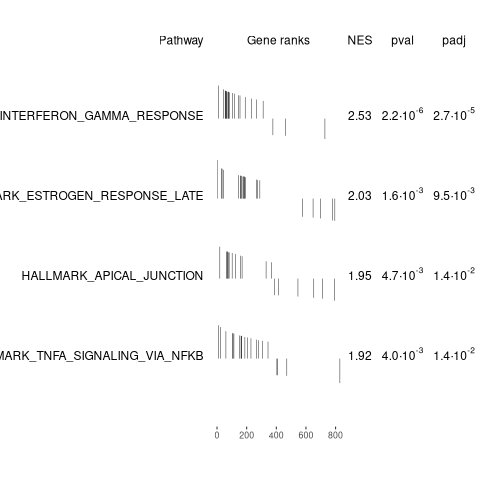

In [111]:
%%R

mainPathways <- fgsea_MOL2_significant[pathway %in% collapsedPathways$mainPathways][
                         order(-NES), pathway]
plotGseaTable(pathwaysH[mainPathways], rankings, fgsea_MOL2_significant, 
              gseaParam = 0.5)

In [112]:
%%R

fgseaResTidy <- fgsea_res %>%
  as_tibble() %>%
  arrange(desc(NES))

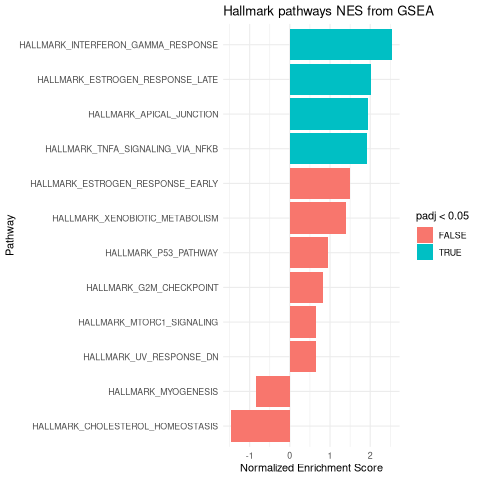

In [113]:
%%R

ggplot(fgseaResTidy, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.05)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score",
       title="Hallmark pathways NES from GSEA") + 
  theme_minimal()


#https://stephenturner.github.io/deseq-to-fgsea/#using_the_fgsea_package

In [114]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.05, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 4 × 4
  pathway                                 padj   NES  size
  <chr>                                  <dbl> <dbl> <int>
1 HALLMARK_INTERFERON_GAMMA_RESPONSE 0.0000265  2.53    22
2 HALLMARK_ESTROGEN_RESPONSE_LATE    0.00953    2.03    21
3 HALLMARK_APICAL_JUNCTION           0.0142     1.95    18
4 HALLMARK_TNFA_SIGNALING_VIA_NFKB   0.0142     1.92    21


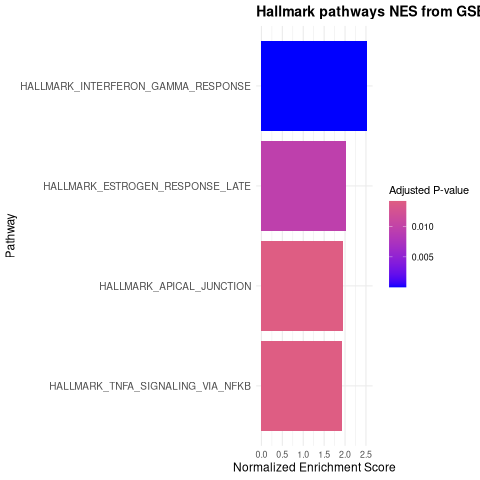

In [115]:
%%R

# Create the ggplot with a color scale for padj
ggplot(fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

In [116]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.05, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 4 × 4
  pathway                                 padj   NES  size
  <chr>                                  <dbl> <dbl> <int>
1 HALLMARK_INTERFERON_GAMMA_RESPONSE 0.0000265  2.53    22
2 HALLMARK_ESTROGEN_RESPONSE_LATE    0.00953    2.03    21
3 HALLMARK_APICAL_JUNCTION           0.0142     1.95    18
4 HALLMARK_TNFA_SIGNALING_VIA_NFKB   0.0142     1.92    21


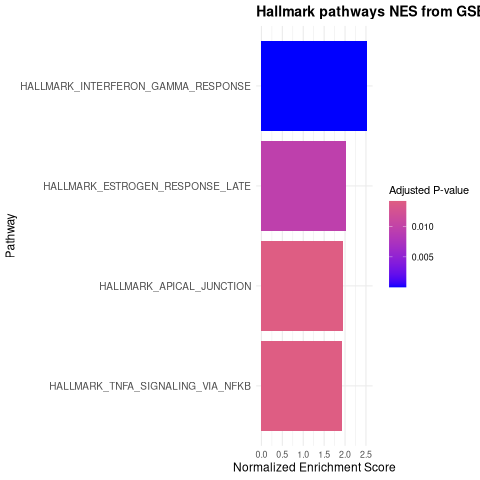

In [117]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgseaResSignificant <- fgseaResSignificant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Create the ggplot with a color scale for padj
ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )


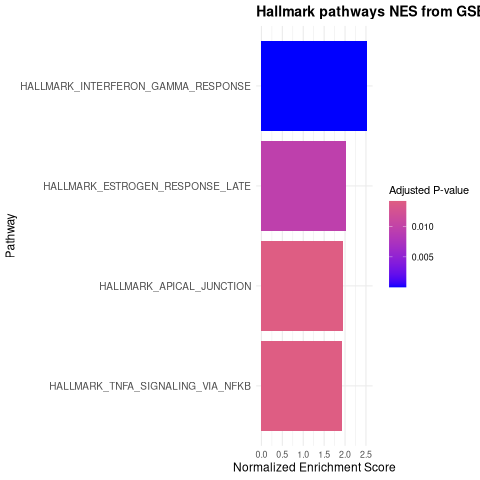

In [118]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

# Save the plot as a high-resolution PNG file
#ggsave("./figures/GSEA/LPC_demyel_MOL_F_hallmark_pathways_NES_GSEA.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

In [119]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
filtered_fgseaResSignificant$pathway <- gsub("^HALLMARK_", "", filtered_fgseaResSignificant$pathway)

# View the updated heatmap_df
head(filtered_fgseaResSignificant)

# A tibble: 4 × 4
  pathway                        padj   NES  size
  <chr>                         <dbl> <dbl> <int>
1 INTERFERON_GAMMA_RESPONSE 0.0000265  2.53    22
2 ESTROGEN_RESPONSE_LATE    0.00953    2.03    21
3 APICAL_JUNCTION           0.0142     1.95    18
4 TNFA_SIGNALING_VIA_NFKB   0.0142     1.92    21


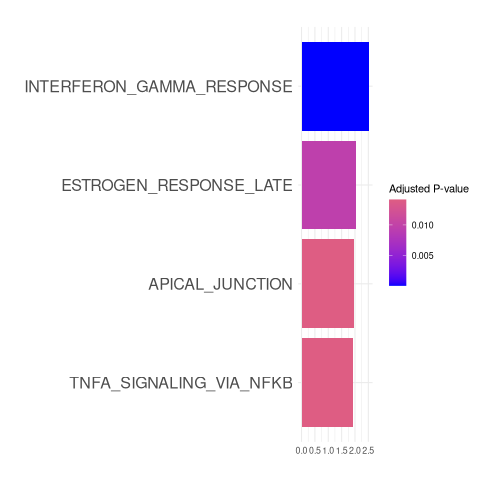

In [120]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "", y = "",
       title = "") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 16),
    axis.title = element_text(size = 16),
    plot.title = element_text(size = 16, face = "bold")
  )

# Save the plot as a high-resolution PNG file
ggsave("./figures/GSEA/LPC_demyel_MOL_F_hallmark_pathways_NES_GSEA_trimmed.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

In [121]:
%%R

filtered_fgseaResSignificant_LPC_demyel <- fgsea_MOL2_significant
# Remove "HALLMARK_" prefix from the 'pathway' column
filtered_fgseaResSignificant_LPC_demyel$pathway <- gsub("^HALLMARK_", "", filtered_fgseaResSignificant_LPC_demyel$pathway)
head(filtered_fgseaResSignificant_LPC_demyel)

                     pathway         pval         padj   log2err        ES
                      <char>        <num>        <num>     <num>     <num>
1:           APICAL_JUNCTION 4.718662e-03 1.415599e-02 0.4070179 0.5268229
2:    ESTROGEN_RESPONSE_LATE 1.588087e-03 9.528522e-03 0.4550599 0.5178293
3: INTERFERON_GAMMA_RESPONSE 2.211376e-06 2.653652e-05 0.6272567 0.6432025
4:   TNFA_SIGNALING_VIA_NFKB 3.971535e-03 1.415599e-02 0.4070179 0.4912544
        NES  size                                  leadingEdge
      <num> <int>                                       <list>
1: 1.950714    18 Col16a1,Inppl1,Nlgn2,Tspan4,Ldlrap1,Flnc,...
2: 2.025713    21    Serpina3n,Snx10,Farp1,Cpe,Aldh3b1,Cd9,...
3: 2.532463    22        Irf9,Mt2,Nlrc5,Eif2ak2,Socs3,Rtp4,...
4: 1.921753    21       Cebpd,Bcl3,Socs3,Ehd1,Fjx1,Gadd45b,...


In [122]:
%%R
unique(filtered_fgseaResSignificant_LPC_demyel$pathway)

[1] "APICAL_JUNCTION"           "ESTROGEN_RESPONSE_LATE"   
[3] "INTERFERON_GAMMA_RESPONSE" "TNFA_SIGNALING_VIA_NFKB"  


In [123]:
%%R

# Define the pathway of interest
pathway_of_interest <- "TNFA_SIGNALING_VIA_NFKB"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_demyel[filtered_fgseaResSignificant_LPC_demyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Cebpd"   "Bcl3"    "Socs3"   "Ehd1"    "Fjx1"    "Gadd45b" "Phlda1" 
 [8] "Gadd45a" "Tsc22d1" "Ccnd1"   "Tiparp"  "Junb"    "Csf1"    "Fos"    
[15] "Plpp3"   "Smad3"  


In [124]:
%%R

# Define the pathway of interest
pathway_of_interest <- "INTERFERON_ALPHA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_demyel[filtered_fgseaResSignificant_LPC_demyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [125]:
%%R

# Define the pathway of interest
pathway_of_interest <- "INTERFERON_GAMMA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_demyel[filtered_fgseaResSignificant_LPC_demyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Irf9"    "Mt2"     "Nlrc5"   "Eif2ak2" "Socs3"   "Rtp4"    "H2-D1"  
 [8] "Parp12"  "B2m"     "Vamp5"   "Ifi35"   "Stat3"   "Usp18"   "Ifi27"  
[15] "Ddx60"  


In [126]:
%%R

# Define the pathway of interest
pathway_of_interest <- "P53_PATHWAY"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_demyel[filtered_fgseaResSignificant_LPC_demyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [127]:
%%R

# Define the pathway of interest
pathway_of_interest <- "COAGULATION"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_demyel[filtered_fgseaResSignificant_LPC_demyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [128]:
%%R

# Define the pathway of interest
pathway_of_interest <- "ESTROGEN_RESPONSE_LATE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_demyel[filtered_fgseaResSignificant_LPC_demyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Serpina3n" "Snx10"     "Farp1"     "Cpe"       "Aldh3b1"   "Cd9"      
 [7] "Add3"      "Ccnd1"     "Fabp5"     "Dynlt3"    "Myof"      "Fam102a"  
[13] "Chst8"    


In [129]:
%%R

# Define the pathway of interest
pathway_of_interest <- "IL6_JAK_STAT3_SIGNALING"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_demyel[filtered_fgseaResSignificant_LPC_demyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [130]:
%%R

# Define the pathway of interest
pathway_of_interest <- "INFLAMMATORY_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_demyel[filtered_fgseaResSignificant_LPC_demyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [131]:
%%R

class(fgsea_MOL2_significant)

[1] "data.table" "data.frame"


In [132]:
%%R

fgsea_MOL2_significant <- as.data.frame(fgsea_MOL2_significant)

In [133]:
%%R
library(data.table)
fwrite(fgsea_MOL2_significant, file = "./files/filtered_fgseaResSignificant_LPC_demyel_MOL_F_NEW.csv")

# LPC_demyel_MOL_E

In [134]:
%%R

# Replace the file path with the actual path if the file is not in the current directory
df <- read.csv("./files/LPC_demyel_MOL_BvE_voom_wqw_REDO.csv")
head(df)  # Display the first few rows of the data frame to confirm it's loaded correctly

     logFC  AveExpr        t      P.Value    adj.P.Val        B    gene
1 4.702341 7.209963 33.74245 2.257351e-14 2.044709e-10 23.12898     C4b
2 4.205148 3.756685 30.59887 8.258574e-14 3.740308e-10 21.33383  Cachd1
3 4.030808 5.957225 27.39822 3.560775e-13 1.075117e-09 20.55361   Masp1
4 3.454752 5.218401 26.29356 6.128776e-13 1.387861e-09 20.02693 Ldlrap1
5 3.138013 5.899677 25.40807 9.625473e-13 1.743751e-09 19.61579  Tspan9
6 3.982897 4.189096 22.67608 4.290371e-12 5.565829e-09 18.05726   Pros1


In [135]:
%%R

dim(df)

[1] 9058    7


In [136]:
%%R

my_genes <- df$gene
head(my_genes)

[1] "C4b"     "Cachd1"  "Masp1"   "Ldlrap1" "Tspan9"  "Pros1"  


In [137]:
%%R
# Check column names in the dataframe
colnames(df)

[1] "logFC"     "AveExpr"   "t"         "P.Value"   "adj.P.Val" "B"        
[7] "gene"     


In [138]:
%%R

# Filter the dataset for significant genes
filtered_df <- df[abs(df$logFC) >= 0.585 & df$adj.P.Val < 0.05, ]

# Compute ranking score: sign(logFC) * -log10(P.Value)
filtered_df$ranking_score <- sign(filtered_df$logFC) * -log10(filtered_df$P.Value)

# Assign names to the rankings
rankings <- filtered_df$ranking_score
names(rankings) <- filtered_df$gene

# Sort the rankings in descending order
rankings <- sort(rankings, decreasing = TRUE)

In [139]:
%%R

# Ensure the length of the gene column matches the length of rankings
length(df$gene) == length(rankings)

[1] FALSE


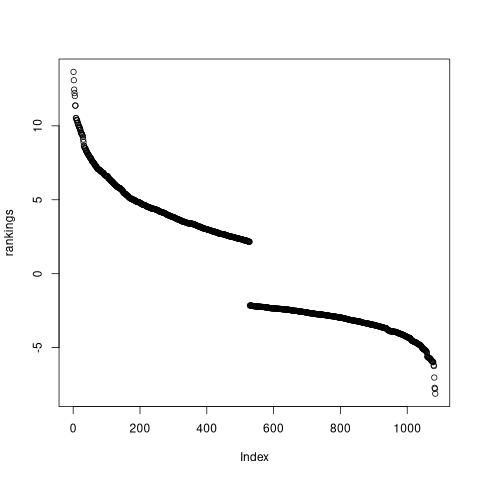

In [140]:
%%R

plot(rankings)

In [141]:
%%R

max(rankings)

[1] 13.6464


In [142]:
%%R

min(rankings)

[1] -8.117186


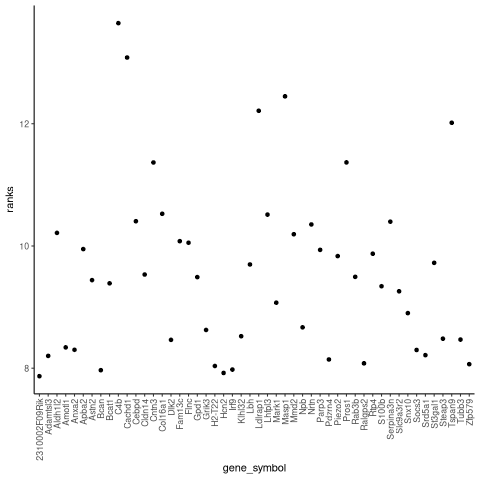

In [143]:
%%R

ggplot(data.frame(gene_symbol = names(rankings)[1:50], ranks = rankings[1:50]), aes(gene_symbol, ranks)) + 
    geom_point() +
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Figure out how to set up gene lists

In [144]:
%%R
fgsea_res <- fgsea(pathways = pathwaysH, 
                  stats    = rankings,
                  scoreType = 'std',
                  minSize  = 15,
                  maxSize  = 500)

In [145]:
%%R
fgsea_res

                                       pathway         pval         padj
                                        <char>        <num>        <num>
 1:                      HALLMARK_ADIPOGENESIS 7.873134e-01 0.7873134328
 2:                   HALLMARK_APICAL_JUNCTION 3.865545e-03 0.0194581060
 3:                       HALLMARK_COAGULATION 3.719008e-02 0.0956316411
 4:                        HALLMARK_COMPLEMENT 2.207084e-01 0.3498759305
 5: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 6.312925e-01 0.7026485987
 6:           HALLMARK_ESTROGEN_RESPONSE_EARLY 2.997997e-02 0.0956316411
 7:            HALLMARK_ESTROGEN_RESPONSE_LATE 1.807388e-01 0.3498759305
 8:                   HALLMARK_HEME_METABOLISM 3.201377e-02 0.0956316411
 9:                           HALLMARK_HYPOXIA 1.143251e-01 0.2572314050
10:               HALLMARK_IL2_STAT5_SIGNALING 2.503401e-01 0.3498759305
11:         HALLMARK_INTERFERON_GAMMA_RESPONSE 5.579070e-06 0.0001004233
12:                 HALLMARK_KRAS_SIGNALING_UP 3.69

In [146]:
%%R

dim(fgsea_res)

[1] 18  8


In [147]:
%%R

fwrite(fgsea_res, file = "./files/fgsea_LPC_demyel_MOL_E_all.csv")

In [151]:
%%R

# Filter for significant results with padj < 0.05
fgsea_MOL2_significant <- fgsea_res %>% filter(padj < 0.1)
dim(fgsea_MOL2_significant)

[1] 7 8


In [152]:
%%R

head(fgsea_MOL2_significant)

                              pathway         pval         padj   log2err
                               <char>        <num>        <num>     <num>
1:           HALLMARK_APICAL_JUNCTION 3.865545e-03 0.0194581060 0.4317077
2:               HALLMARK_COAGULATION 3.719008e-02 0.0956316411 0.2765006
3:   HALLMARK_ESTROGEN_RESPONSE_EARLY 2.997997e-02 0.0956316411 0.3524879
4:           HALLMARK_HEME_METABOLISM 3.201377e-02 0.0956316411 0.3217759
5: HALLMARK_INTERFERON_GAMMA_RESPONSE 5.579070e-06 0.0001004233 0.6105269
6:         HALLMARK_KRAS_SIGNALING_UP 3.698422e-03 0.0194581060 0.4317077
           ES       NES  size                                 leadingEdge
        <num>     <num> <int>                                      <list>
1:  0.4802883  1.953115    26  Ldlrap1,Col16a1,Nrtn,Flnc,Cldn14,Thbs3,...
2:  0.4702043  1.604244    15        Pros1,Bmp1,Klk8,Gsn,Sparc,S100a1,...
3: -0.3605303 -1.713591    18 Igf1r,Slc24a3,Svil,Tob1,Retreg1,Rhobtb3,...
4: -0.3380414 -1.739365    22    Fbxo7

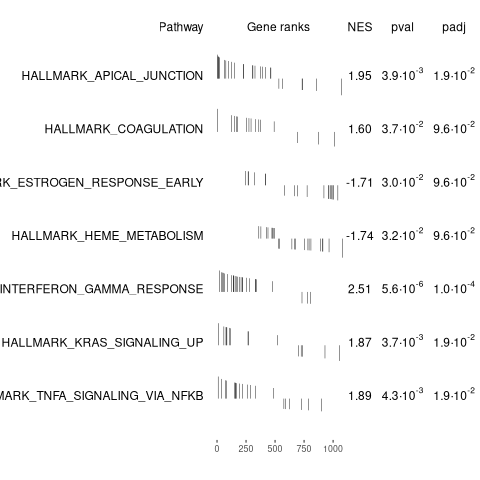

In [153]:
%%R

plotGseaTable(pathwaysH[fgsea_MOL2_significant$pathway], 
              rankings, 
              fgsea_MOL2_significant, 
              gseaParam = 0.5)

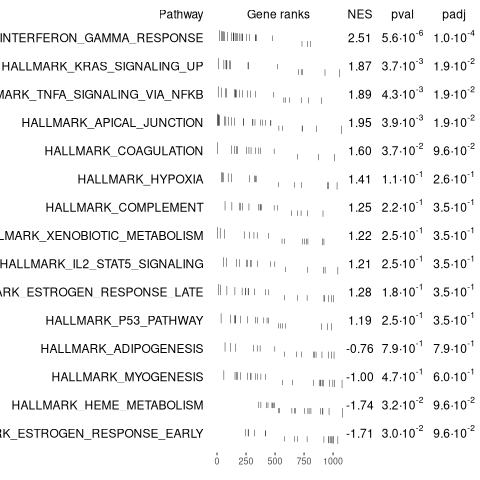

In [154]:
%%R

topUp <- fgsea_res %>% 
    filter(ES > 0) %>% 
    top_n(10, wt=-padj)
topDown <- fgsea_res %>% 
    filter(ES < 0) %>% 
    top_n(10, wt=-padj)
topPathways <- bind_rows(topUp, topDown) %>% 
    arrange(-ES)
plotGseaTable(pathwaysH[topPathways$pathway], 
              rankings, 
              fgsea_res, 
              gseaParam = 0.5)

In [155]:
%%R

collapsedPathways <- collapsePathways(fgsea_MOL2_significant[order(pval)][padj < 0.05], 
                                      pathwaysH, rankings)

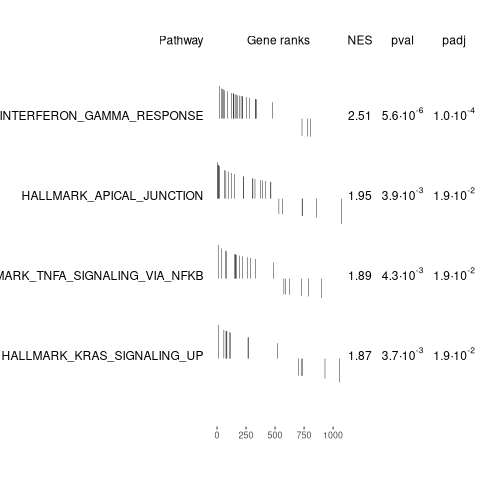

In [156]:
%%R

mainPathways <- fgsea_MOL2_significant[pathway %in% collapsedPathways$mainPathways][
                         order(-NES), pathway]
plotGseaTable(pathwaysH[mainPathways], rankings, fgsea_MOL2_significant, 
              gseaParam = 0.5)

In [157]:
%%R

fgseaResTidy <- fgsea_res %>%
  as_tibble() %>%
  arrange(desc(NES))

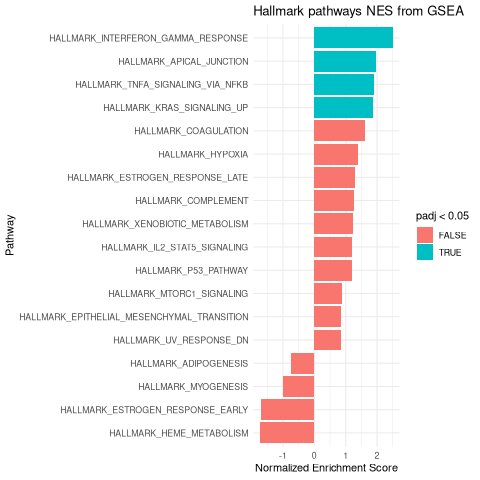

In [158]:
%%R

ggplot(fgseaResTidy, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.05)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score",
       title="Hallmark pathways NES from GSEA") + 
  theme_minimal()


#https://stephenturner.github.io/deseq-to-fgsea/#using_the_fgsea_package

In [159]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.05, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 4 × 4
  pathway                                padj   NES  size
  <chr>                                 <dbl> <dbl> <int>
1 HALLMARK_INTERFERON_GAMMA_RESPONSE 0.000100  2.51    26
2 HALLMARK_APICAL_JUNCTION           0.0195    1.95    26
3 HALLMARK_TNFA_SIGNALING_VIA_NFKB   0.0195    1.89    20
4 HALLMARK_KRAS_SIGNALING_UP         0.0195    1.87    15


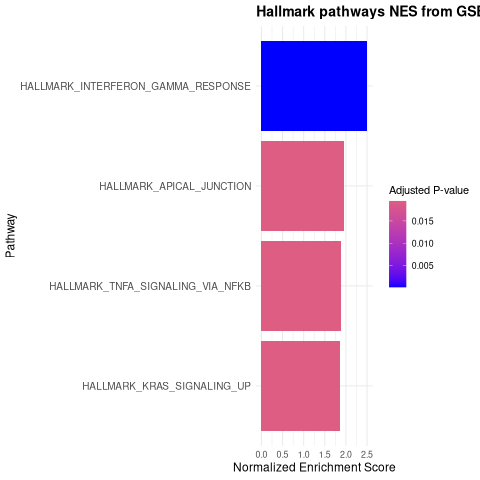

In [160]:
%%R

# Create the ggplot with a color scale for padj
ggplot(fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

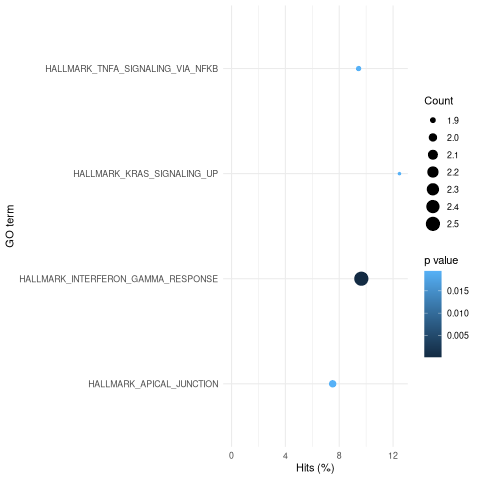

In [161]:
%%R

# Calculate hits percentage (if 'numDEInCat' and 'numInCat' equivalent are 'NES' and 'size')
fgseaResSignificant <- fgseaResSignificant %>%
  mutate(hitsPerc = NES * 100 / size)

# Ensure the columns 'padj' and 'NES' are present for the plot
fgseaResSignificant <- fgseaResSignificant %>%
  rename(term = pathway, over_represented_pvalue = padj, numDEInCat = NES)

# Create the plot
ggplot(fgseaResSignificant, aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
  geom_point() +
  expand_limits(x = 0) +
  labs(x = "Hits (%)", y = "GO term", colour = "p value", size = "Count") +
  theme_minimal()

#https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2018/RNASeq2018/html/06_Gene_set_testing.nb.html

In [162]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.05, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 4 × 4
  pathway                                padj   NES  size
  <chr>                                 <dbl> <dbl> <int>
1 HALLMARK_INTERFERON_GAMMA_RESPONSE 0.000100  2.51    26
2 HALLMARK_APICAL_JUNCTION           0.0195    1.95    26
3 HALLMARK_TNFA_SIGNALING_VIA_NFKB   0.0195    1.89    20
4 HALLMARK_KRAS_SIGNALING_UP         0.0195    1.87    15


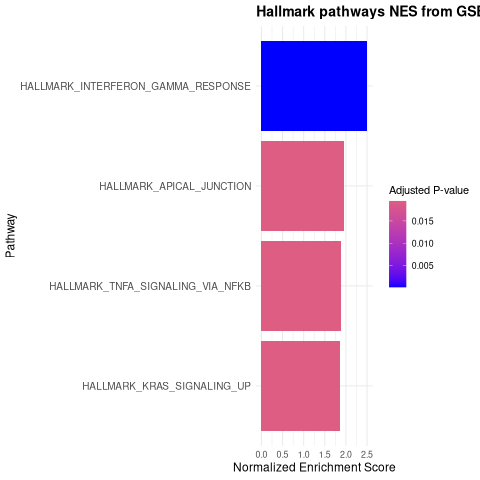

In [163]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgseaResSignificant <- fgseaResSignificant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Create the ggplot with a color scale for padj
ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )


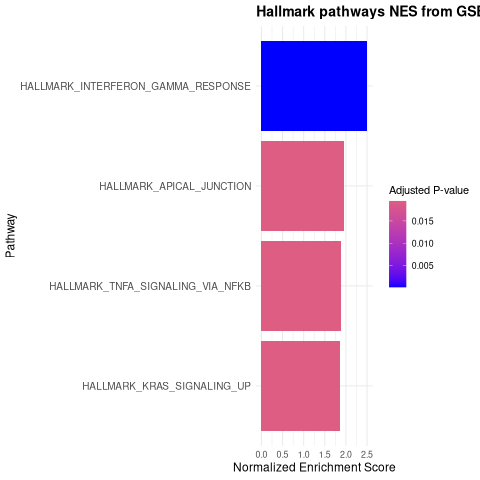

In [164]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

# Save the plot as a high-resolution PNG file
#ggsave("./figures/GSEA/LPC_demyel_MOL_E_hallmark_pathways_NES_GSEA.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

In [165]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
filtered_fgseaResSignificant$pathway <- gsub("^HALLMARK_", "", filtered_fgseaResSignificant$pathway)

# View the updated heatmap_df
head(filtered_fgseaResSignificant)

# A tibble: 4 × 4
  pathway                       padj   NES  size
  <chr>                        <dbl> <dbl> <int>
1 INTERFERON_GAMMA_RESPONSE 0.000100  2.51    26
2 APICAL_JUNCTION           0.0195    1.95    26
3 TNFA_SIGNALING_VIA_NFKB   0.0195    1.89    20
4 KRAS_SIGNALING_UP         0.0195    1.87    15


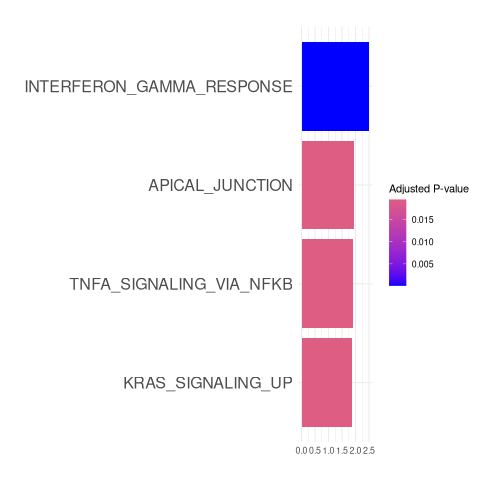

In [166]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "", y = "",
       title = "") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 16),
    axis.title = element_text(size = 16),
    plot.title = element_text(size = 16, face = "bold")
  )

# Save the plot as a high-resolution PNG file
ggsave("./figures/GSEA/LPC_demyel_MOL_E_hallmark_pathways_NES_GSEA_trimmed.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

In [167]:
%%R

filtered_fgseaResSignificant_LPC_demyel <- fgsea_MOL2_significant
# Remove "HALLMARK_" prefix from the 'pathway' column
filtered_fgseaResSignificant_LPC_demyel$pathway <- gsub("^HALLMARK_", "", filtered_fgseaResSignificant_LPC_demyel$pathway)
head(filtered_fgseaResSignificant_LPC_demyel)

                     pathway         pval         padj   log2err         ES
                      <char>        <num>        <num>     <num>      <num>
1:           APICAL_JUNCTION 3.865545e-03 0.0194581060 0.4317077  0.4802883
2:               COAGULATION 3.719008e-02 0.0956316411 0.2765006  0.4702043
3:   ESTROGEN_RESPONSE_EARLY 2.997997e-02 0.0956316411 0.3524879 -0.3605303
4:           HEME_METABOLISM 3.201377e-02 0.0956316411 0.3217759 -0.3380414
5: INTERFERON_GAMMA_RESPONSE 5.579070e-06 0.0001004233 0.6105269  0.6164789
6:         KRAS_SIGNALING_UP 3.698422e-03 0.0194581060 0.4317077  0.5484427
         NES  size                                 leadingEdge
       <num> <int>                                      <list>
1:  1.953115    26  Ldlrap1,Col16a1,Nrtn,Flnc,Cldn14,Thbs3,...
2:  1.604244    15        Pros1,Bmp1,Klk8,Gsn,Sparc,S100a1,...
3: -1.713591    18 Igf1r,Slc24a3,Svil,Tob1,Retreg1,Rhobtb3,...
4: -1.739365    22    Fbxo7,Mboat2,Slc6a9,Pcx,Xpo7,Aldh6a1,...
5:  2.506940  

In [168]:
%%R
unique(filtered_fgseaResSignificant_LPC_demyel$pathway)

[1] "APICAL_JUNCTION"           "COAGULATION"              
[3] "ESTROGEN_RESPONSE_EARLY"   "HEME_METABOLISM"          
[5] "INTERFERON_GAMMA_RESPONSE" "KRAS_SIGNALING_UP"        
[7] "TNFA_SIGNALING_VIA_NFKB"  


In [169]:
%%R

# Define the pathway of interest
pathway_of_interest <- "TNFA_SIGNALING_VIA_NFKB"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_demyel[filtered_fgseaResSignificant_LPC_demyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Cebpd"   "Socs3"   "Bcl3"    "Csf1"    "Plpp3"   "Tsc22d1" "Gadd45a"
 [8] "Tubb2a"  "Spsb1"   "Ehd1"    "Phlda1"  "Gadd45b" "Cdkn1a" 


In [170]:
%%R

# Define the pathway of interest
pathway_of_interest <- "INTERFERON_ALPHA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_demyel[filtered_fgseaResSignificant_LPC_demyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [171]:
%%R

# Define the pathway of interest
pathway_of_interest <- "INTERFERON_GAMMA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_demyel[filtered_fgseaResSignificant_LPC_demyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Rtp4"    "Socs3"   "Irf9"    "Gbp3"    "Ifi35"   "H2-D1"   "B2m"    
 [8] "Stat3"   "Rnf213"  "Parp12"  "Vamp5"   "Ifi27"   "Stat2"   "Usp18"  
[15] "Herc6"   "Ddx60"   "Eif2ak2" "Stat1"   "Mt2"     "Cdkn1a"  "Tapbp"  
[22] "Mvp"    


In [172]:
%%R

# Define the pathway of interest
pathway_of_interest <- "P53_PATHWAY"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_demyel[filtered_fgseaResSignificant_LPC_demyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [173]:
%%R

# Define the pathway of interest
pathway_of_interest <- "COAGULATION"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_demyel[filtered_fgseaResSignificant_LPC_demyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Pros1"  "Bmp1"   "Klk8"   "Gsn"    "Sparc"  "S100a1" "Cpq"    "Sirt2" 
 [9] "Trf"    "Lamp2"  "Adam9" 


In [174]:
%%R

# Define the pathway of interest
pathway_of_interest <- "ESTROGEN_RESPONSE_LATE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_demyel[filtered_fgseaResSignificant_LPC_demyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [175]:
%%R

# Define the pathway of interest
pathway_of_interest <- "IL6_JAK_STAT3_SIGNALING"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_demyel[filtered_fgseaResSignificant_LPC_demyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [176]:
%%R

# Define the pathway of interest
pathway_of_interest <- "INFLAMMATORY_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_demyel[filtered_fgseaResSignificant_LPC_demyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [177]:
%%R

class(fgsea_MOL2_significant)

[1] "data.table" "data.frame"


In [178]:
%%R

fgsea_MOL2_significant <- as.data.frame(fgsea_MOL2_significant)

In [179]:
%%R
library(data.table)
fwrite(fgsea_MOL2_significant, file = "./files/filtered_fgseaResSignificant_LPC_demyel_MOL_E_NEW.csv")

# LPC_remyel_MOL_E

In [9]:
%%R

# Replace the file path with the actual path if the file is not in the current directory
df <- read.csv("./files/LPC_remyel_MOL_BvE_voom_wqw.csv")
head(df)  # Display the first few rows of the data frame to confirm it's loaded correctly

       gene    logFC  AveExpr        t      P.Value    adj.P.Val        B
1       C4b 5.950542 7.275518 37.75992 9.039043e-16 1.024756e-11 25.40311
2 Serpina3n 7.867647 5.052831 24.69132 3.671651e-13 2.081275e-09 18.31709
3     Anxa2 6.543960 4.230177 20.60690 4.599083e-12 1.564695e-08 16.65643
4  Slc9a3r2 3.659691 6.653274 20.33799 5.520668e-12 1.564695e-08 17.89199
5     Cebpd 3.533207 4.929288 17.91646 3.190794e-11 6.688340e-08 16.07010
6       B2m 4.228047 6.321066 17.78193 3.539741e-11 6.688340e-08 16.06318


In [10]:
%%R

dim(df)

[1] 11337     7


In [11]:
%%R

my_genes <- df$gene
head(my_genes)

[1] "C4b"       "Serpina3n" "Anxa2"     "Slc9a3r2"  "Cebpd"     "B2m"      


In [12]:
%%R
# Check column names in the dataframe
colnames(df)

[1] "gene"      "logFC"     "AveExpr"   "t"         "P.Value"   "adj.P.Val"
[7] "B"        


In [13]:
%%R

# Filter the dataset for significant genes
filtered_df <- df[abs(df$logFC) >= 0.585 & df$adj.P.Val < 0.05, ]

# Compute ranking score: sign(logFC) * -log10(P.Value)
filtered_df$ranking_score <- sign(filtered_df$logFC) * -log10(filtered_df$P.Value)

# Assign names to the rankings
rankings <- filtered_df$ranking_score
names(rankings) <- filtered_df$gene

# Sort the rankings in descending order
rankings <- sort(rankings, decreasing = TRUE)

In [14]:
%%R

# Ensure the length of the gene column matches the length of rankings
length(df$gene) == length(rankings)

[1] FALSE


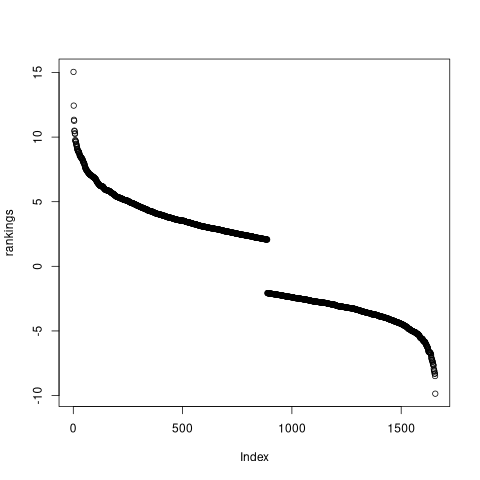

In [15]:
%%R

plot(rankings)

In [16]:
%%R

max(rankings)

[1] 15.04388


In [17]:
%%R

min(rankings)

[1] -9.855538


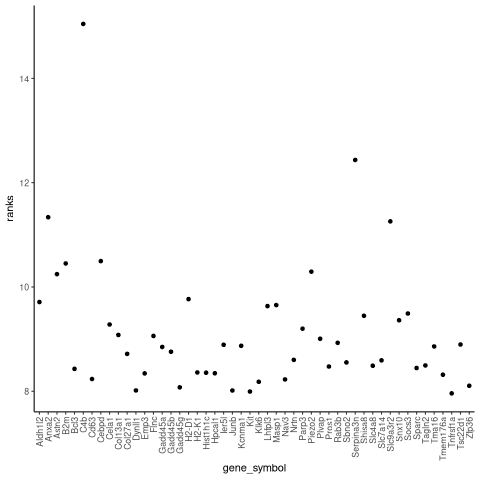

In [18]:
%%R

ggplot(data.frame(gene_symbol = names(rankings)[1:50], ranks = rankings[1:50]), aes(gene_symbol, ranks)) + 
    geom_point() +
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Figure out how to set up gene lists

In [19]:
%%R
fgsea_res <- fgsea(pathways = pathwaysH, 
                  stats    = rankings,
                  scoreType = 'std',
                  minSize  = 15,
                  maxSize  = 500)

In [20]:
%%R
fgsea_res

                                       pathway         pval         padj
                                        <char>        <num>        <num>
 1:                      HALLMARK_ADIPOGENESIS 1.693908e-01 0.2661855232
 2:               HALLMARK_ALLOGRAFT_REJECTION 1.946203e-01 0.2919303797
 3:                 HALLMARK_ANDROGEN_RESPONSE 5.824666e-01 0.6628067838
 4:                   HALLMARK_APICAL_JUNCTION 3.299752e-02 0.0777798755
 5:                         HALLMARK_APOPTOSIS 3.440595e-03 0.0141924554
 6:              HALLMARK_BILE_ACID_METABOLISM 7.347561e-01 0.7577172256
 7:           HALLMARK_CHOLESTEROL_HOMEOSTASIS 4.832827e-01 0.6133972411
 8:                       HALLMARK_COAGULATION 6.315344e-04 0.0029772338
 9:                        HALLMARK_COMPLEMENT 1.396055e-01 0.2462291399
10: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 4.003072e-03 0.0146779323
11:           HALLMARK_ESTROGEN_RESPONSE_EARLY 1.587302e-01 0.2619047619
12:            HALLMARK_ESTROGEN_RESPONSE_LATE 1.55

In [21]:
%%R

dim(fgsea_res)

[1] 33  8


In [23]:
%%R
library(data.table)

fwrite(fgsea_res, file = "./files/fgsea_LPC_remyel_MOL_F_all.csv")

data.table 1.16.4 using 8 threads (see ?getDTthreads).  Latest news: r-datatable.com

Attaching package: ‘data.table’

The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [24]:
%%R

# Filter for significant results with padj < 0.05
fgsea_MOL4_significant <- fgsea_res %>% filter(padj < 0.1)
dim(fgsea_MOL4_significant)

[1] 15  8


In [25]:
%%R

head(fgsea_MOL4_significant)

                                      pathway         pval         padj
                                       <char>        <num>        <num>
1:                   HALLMARK_APICAL_JUNCTION 0.0329975229 0.0777798755
2:                         HALLMARK_APOPTOSIS 0.0034405953 0.0141924554
3:                       HALLMARK_COAGULATION 0.0006315344 0.0029772338
4: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 0.0040030725 0.0146779323
5:            HALLMARK_ESTROGEN_RESPONSE_LATE 0.0001550995 0.0009525209
6:                        HALLMARK_GLYCOLYSIS 0.0433161299 0.0952954857
     log2err        ES      NES  size                              leadingEdge
       <num>     <num>    <num> <int>                                   <list>
1: 0.3217759 0.3634287 1.668781    32   Flnc,Nrtn,Bmp1,Thbs3,Cldn14,Tspan4,...
2: 0.4317077 0.4816722 1.982805    22 Gadd45a,Gadd45b,Eno2,Irf1,Tspo,Hmox1,...
3: 0.4772708 0.5784212 2.133113    16       Pros1,Sparc,Bmp1,Cpq,Cd9,Adam9,...
4: 0.4070179 0.4342962 1.9143

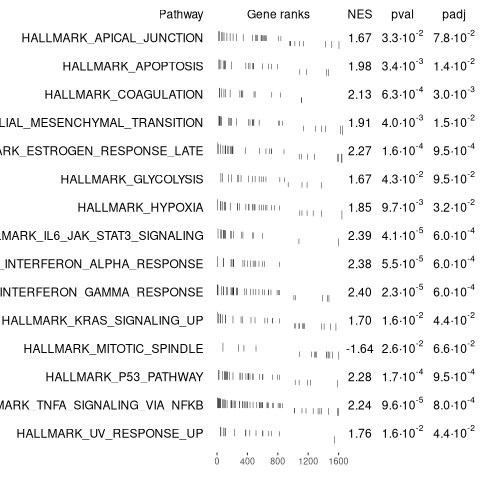

In [26]:
%%R

plotGseaTable(pathwaysH[fgsea_MOL4_significant$pathway], 
              rankings, 
              fgsea_MOL4_significant, 
              gseaParam = 0.5)

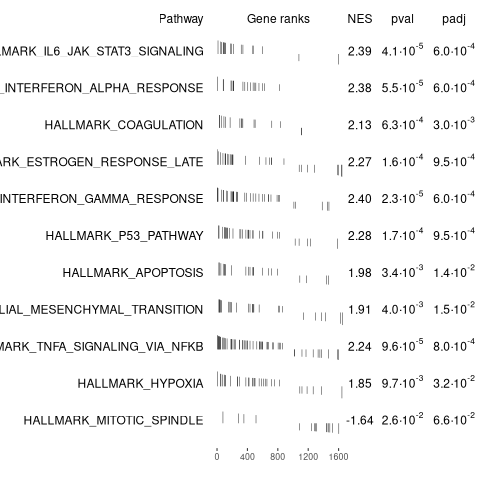

In [27]:
%%R

topUp <- fgsea_MOL4_significant %>% 
    filter(ES > 0) %>% 
    top_n(10, wt=-padj)

topDown <- fgsea_MOL4_significant %>% 
    filter(ES < 0) %>% 
    top_n(10, wt=-padj)

topPathways <- bind_rows(topUp, topDown) %>% 
    arrange(-ES)

plotGseaTable(pathwaysH[topPathways$pathway], 
              rankings, 
              fgsea_MOL4_significant, 
              gseaParam = 0.5)

In [28]:
%%R

collapsedPathways <- collapsePathways(fgsea_MOL4_significant[order(pval)][padj < 0.05], 
                                      pathwaysH, rankings)

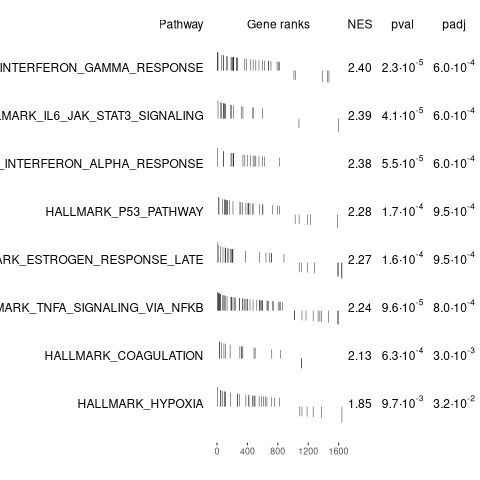

In [29]:
%%R

mainPathways <- fgsea_MOL4_significant[pathway %in% collapsedPathways$mainPathways][
                         order(-NES), pathway]
plotGseaTable(pathwaysH[mainPathways], rankings, fgsea_MOL4_significant, 
              gseaParam = 0.5)

In [30]:
%%R

fgseaResTidy <- fgsea_res %>%
  as_tibble() %>%
  arrange(desc(NES))

In [31]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.05, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 6 × 4
  pathway                                padj   NES  size
  <chr>                                 <dbl> <dbl> <int>
1 HALLMARK_INTERFERON_GAMMA_RESPONSE 0.000602  2.40    37
2 HALLMARK_IL6_JAK_STAT3_SIGNALING   0.000602  2.39    18
3 HALLMARK_INTERFERON_ALPHA_RESPONSE 0.000602  2.38    19
4 HALLMARK_TNFA_SIGNALING_VIA_NFKB   0.000795  2.24    56
5 HALLMARK_P53_PATHWAY               0.000953  2.28    32
6 HALLMARK_ESTROGEN_RESPONSE_LATE    0.000953  2.27    29


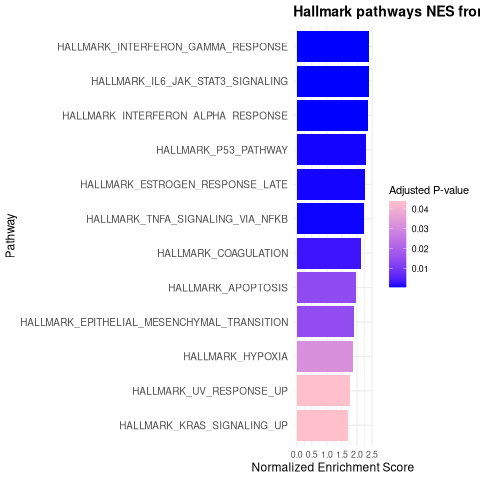

In [33]:
%%R

# Create the ggplot with a color scale for padj
ggplot(fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "blue", high = "pink", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

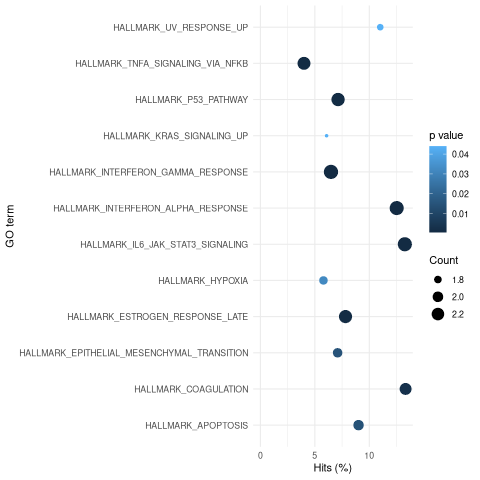

In [34]:
%%R

# Calculate hits percentage (if 'numDEInCat' and 'numInCat' equivalent are 'NES' and 'size')
fgseaResSignificant <- fgseaResSignificant %>%
  mutate(hitsPerc = NES * 100 / size)

# Ensure the columns 'padj' and 'NES' are present for the plot
fgseaResSignificant <- fgseaResSignificant %>%
  rename(term = pathway, over_represented_pvalue = padj, numDEInCat = NES)

# Create the plot
ggplot(fgseaResSignificant, aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
  geom_point() +
  expand_limits(x = 0) +
  labs(x = "Hits (%)", y = "GO term", colour = "p value", size = "Count") +
  theme_minimal()

#https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2018/RNASeq2018/html/06_Gene_set_testing.nb.html

In [35]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.05, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 6 × 4
  pathway                                padj   NES  size
  <chr>                                 <dbl> <dbl> <int>
1 HALLMARK_INTERFERON_GAMMA_RESPONSE 0.000602  2.40    37
2 HALLMARK_IL6_JAK_STAT3_SIGNALING   0.000602  2.39    18
3 HALLMARK_INTERFERON_ALPHA_RESPONSE 0.000602  2.38    19
4 HALLMARK_TNFA_SIGNALING_VIA_NFKB   0.000795  2.24    56
5 HALLMARK_P53_PATHWAY               0.000953  2.28    32
6 HALLMARK_ESTROGEN_RESPONSE_LATE    0.000953  2.27    29


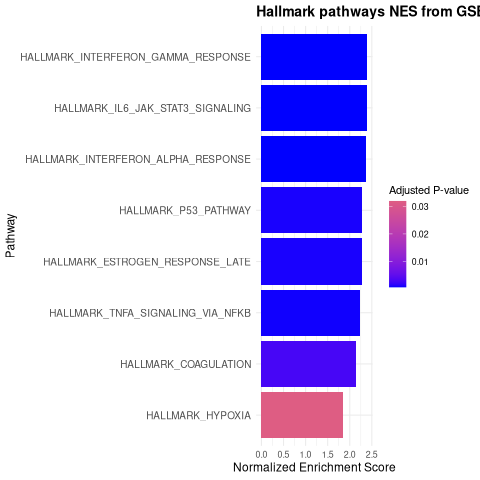

In [36]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgseaResSignificant <- fgseaResSignificant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Create the ggplot with a color scale for padj
ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )


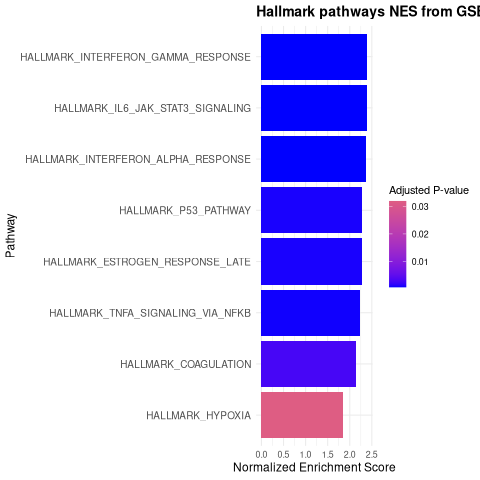

In [37]:
%%R

# Create the ggplot
plot <- # Create the ggplot with a color scale for padj
ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

# Save the plot as a high-resolution PNG file
#ggsave("./figures/GSEA/LPC_remyel_MOL_E_reduced_hallmark_pathways_NES_GSEA.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

In [38]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
filtered_fgseaResSignificant$pathway <- gsub("^HALLMARK_", "", filtered_fgseaResSignificant$pathway)

# View the updated heatmap_df
head(filtered_fgseaResSignificant)

# A tibble: 6 × 4
  pathway                       padj   NES  size
  <chr>                        <dbl> <dbl> <int>
1 INTERFERON_GAMMA_RESPONSE 0.000602  2.40    37
2 IL6_JAK_STAT3_SIGNALING   0.000602  2.39    18
3 INTERFERON_ALPHA_RESPONSE 0.000602  2.38    19
4 TNFA_SIGNALING_VIA_NFKB   0.000795  2.24    56
5 P53_PATHWAY               0.000953  2.28    32
6 ESTROGEN_RESPONSE_LATE    0.000953  2.27    29


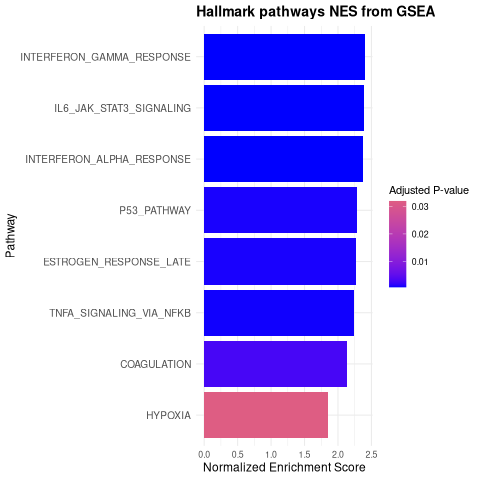

In [39]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

# Save the plot as a high-resolution PNG file
#ggsave("./figures/GSEA/LPC_remyel_MOL_hallmark_pathways_NES_GSEA_trimmed.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

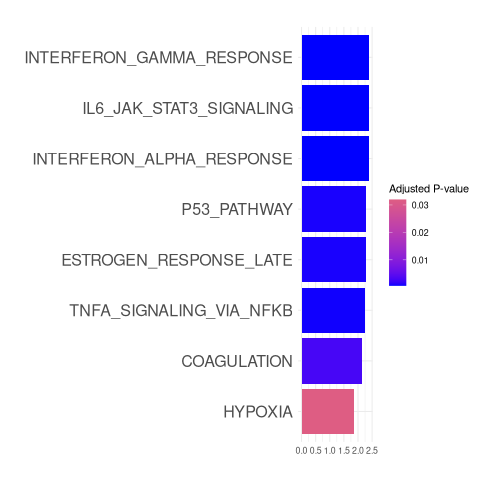

In [40]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "", y = "",
       title = "") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 16),
    axis.title = element_text(size = 16),
    plot.title = element_text(size = 16, face = "bold")
  )

# Save the plot as a high-resolution PNG file
ggsave("./figures/GSEA/LPC_remyel_MOL_E_hallmark_pathways_NES_GSEA_trimmed.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

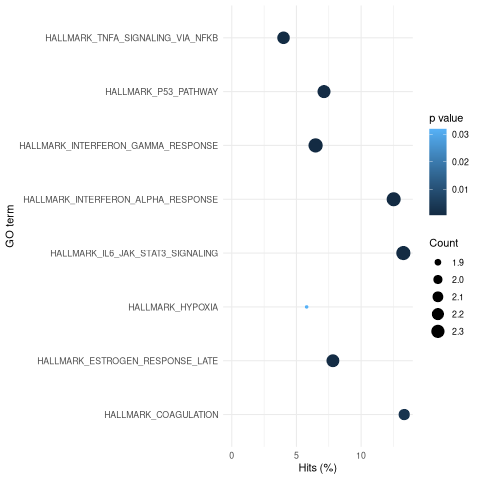

In [41]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgseaResSignificant <- fgseaResSignificant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Calculate hits percentage
filtered_fgseaResSignificant <- filtered_fgseaResSignificant %>%
  mutate(hitsPerc = NES * 100 / size)

# Ensure the columns 'padj' and 'NES' are present for the plot
filtered_fgseaResSignificant <- filtered_fgseaResSignificant %>%
  rename(term = pathway, over_represented_pvalue = padj, numDEInCat = NES)

# Create the plot
ggplot(filtered_fgseaResSignificant, aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
  geom_point() +
  expand_limits(x = 0) +
  labs(x = "Hits (%)", y = "GO term", colour = "p value", size = "Count") +
  theme_minimal()


In [42]:
%%R

filtered_fgseaResSignificant_LPC_remyel <- fgsea_MOL4_significant
# Remove "HALLMARK_" prefix from the 'pathway' column
filtered_fgseaResSignificant_LPC_remyel$pathway <- gsub("^HALLMARK_", "", filtered_fgseaResSignificant_LPC_remyel$pathway)
head(filtered_fgseaResSignificant_LPC_remyel)

                             pathway         pval         padj   log2err
                              <char>        <num>        <num>     <num>
1:                   APICAL_JUNCTION 0.0329975229 0.0777798755 0.3217759
2:                         APOPTOSIS 0.0034405953 0.0141924554 0.4317077
3:                       COAGULATION 0.0006315344 0.0029772338 0.4772708
4: EPITHELIAL_MESENCHYMAL_TRANSITION 0.0040030725 0.0146779323 0.4070179
5:            ESTROGEN_RESPONSE_LATE 0.0001550995 0.0009525209 0.5188481
6:                        GLYCOLYSIS 0.0433161299 0.0952954857 0.3217759
          ES      NES  size                              leadingEdge
       <num>    <num> <int>                                   <list>
1: 0.3634287 1.668781    32   Flnc,Nrtn,Bmp1,Thbs3,Cldn14,Tspan4,...
2: 0.4816722 1.982805    22 Gadd45a,Gadd45b,Eno2,Irf1,Tspo,Hmox1,...
3: 0.5784212 2.133113    16       Pros1,Sparc,Bmp1,Cpq,Cd9,Adam9,...
4: 0.4342962 1.914305    27 Gadd45a,Gadd45b,Sparc,Emp3,Eno2,Bmp1,...
5:

In [43]:
%%R
unique(filtered_fgseaResSignificant_LPC_remyel$pathway)

 [1] "APICAL_JUNCTION"                   "APOPTOSIS"                        
 [3] "COAGULATION"                       "EPITHELIAL_MESENCHYMAL_TRANSITION"
 [5] "ESTROGEN_RESPONSE_LATE"            "GLYCOLYSIS"                       
 [7] "HYPOXIA"                           "IL6_JAK_STAT3_SIGNALING"          
 [9] "INTERFERON_ALPHA_RESPONSE"         "INTERFERON_GAMMA_RESPONSE"        
[11] "KRAS_SIGNALING_UP"                 "MITOTIC_SPINDLE"                  
[13] "P53_PATHWAY"                       "TNFA_SIGNALING_VIA_NFKB"          
[15] "UV_RESPONSE_UP"                   


In [44]:
%%R

# Define the pathway of interest
pathway_of_interest <- "TNFA_SIGNALING_VIA_NFKB"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_remyel[filtered_fgseaResSignificant_LPC_remyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Cebpd"   "Socs3"   "Tsc22d1" "Gadd45a" "Gadd45b" "Bcl3"    "Zfp36"  
 [8] "Junb"    "Fosl2"   "Irf1"    "Abca1"   "Fos"     "Tnfsf9"  "Plpp3"  
[15] "Phlda1"  "Cd44"    "Klf4"    "Cebpb"   "Fjx1"    "Nfil3"   "Kdm6b"  
[22] "Spsb1"   "Csf1"    "Slc16a6" "Atf3"    "Per1"    "Bcl6"   


In [45]:
%%R

# Define the pathway of interest
pathway_of_interest <- "INTERFERON_ALPHA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_remyel[filtered_fgseaResSignificant_LPC_remyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "B2m"     "Irf1"    "Irf9"    "Rtp4"    "Ifi35"   "Parp12"  "Ifi27"  
 [8] "Bst2"    "Csf1"    "Ddx60"   "Tent5a"  "Eif2ak2" "Trim25"  "Tmem140"
[15] "Herc6"   "Usp18"   "Stat2"   "Psme1"  


In [46]:
%%R

# Define the pathway of interest
pathway_of_interest <- "INTERFERON_GAMMA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_remyel[filtered_fgseaResSignificant_LPC_remyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "B2m"    "H2-D1"  "Socs3"  "Stat1"  "Irf1"   "Irf9"   "Mvp"    "Vamp8" 
 [9] "Rtp4"   "Ifi35"  "Fgl2"   "Parp12" "Ifi27"  "Bst2"   "Stat3"  "Nlrc5" 
[17] "Vamp5"  "Mt2"   


In [47]:
%%R

# Define the pathway of interest
pathway_of_interest <- "IL6_JAK_STAT3_SIGNALING"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_remyel[filtered_fgseaResSignificant_LPC_remyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Socs3"    "Tnfrsf1a" "Stat1"    "Irf1"     "Irf9"     "Cntfr"   
 [7] "Hmox1"    "Cd9"      "Ltbr"     "Cd44"     "Stat3"    "Il3ra"   
[13] "Csf1"    


In [48]:
%%R

# Define the pathway of interest
pathway_of_interest <- "INFLAMMATORY_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_remyel[filtered_fgseaResSignificant_LPC_remyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [49]:
%%R

# Define the pathway of interest
pathway_of_interest <- "CHOLESTEROL_HOMEOSTASIS"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_remyel[filtered_fgseaResSignificant_LPC_remyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [50]:
%%R

# Define the pathway of interest
pathway_of_interest <- "ESTROGEN_RESPONSE_LATE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_remyel[filtered_fgseaResSignificant_LPC_remyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Serpina3n" "Snx10"     "Zfp36"     "Farp1"     "Myof"      "Fos"      
 [7] "Cd9"       "Chst8"     "Unc13b"    "Cyp26b1"   "Cd44"      "Fabp5"    
[13] "Cxcl14"    "Klf4"     


In [51]:
%%R

# Define the pathway of interest
pathway_of_interest <- "P53_PATHWAY"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_remyel[filtered_fgseaResSignificant_LPC_remyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Tsc22d1" "Gadd45a" "Steap3"  "S100a10" "Hmox1"   "Fos"     "Dgka"   
 [8] "Tnfsf9"  "Vamp8"   "Cdh13"   "Klf4"    "Klk8"    "Tnni1"   "Vwa5a"  
[15] "Atf3"    "Ralgds"  "Tax1bp3" "Sdc1"    "Sat1"    "Mdm2"    "Jun"    


In [52]:
%%R

class(fgsea_MOL4_significant)

[1] "data.table" "data.frame"


In [53]:
%%R

fgsea_MOL4_significant <- as.data.frame(fgsea_MOL4_significant)

In [54]:
%%R
library(data.table)
fwrite(fgsea_MOL4_significant, file = "./files/filtered_fgseaResSignificant_LPC_remyel_MOL_E_NEW.csv")

# Cupr_demyel_MOL

In [55]:
%%R

# Replace the file path with the actual path if the file is not in the current directory
df <- read.csv("./files/Cupr_demyel_MOL_AvG_voom_wqw_NEW.csv")
head(df)  # Display the first few rows of the data frame to confirm it's loaded correctly

    gene     logFC  AveExpr         t      P.Value    adj.P.Val        B
1  Ninj2 -4.607284 6.748263 -26.10690 3.340235e-13 1.718217e-09 20.37725
2   Jph4 -5.682385 3.820698 -23.27667 1.590012e-12 4.089510e-09 18.20506
3  Ptgds -5.227826 9.807530 -22.13151 3.149304e-12 5.400007e-09 18.46735
4   Sgk2 -7.897536 2.657387 -21.03121 6.272674e-12 8.066659e-09 16.15682
5 Ccp110 -3.185825 6.733613 -19.94428 1.282088e-11 1.319012e-08 16.95061
6   Aspa -2.423516 8.778888 -18.52569 3.450224e-11 2.379544e-08 16.11846


In [56]:
%%R

dim(df)

[1] 5144    7


In [57]:
%%R

my_genes <- df$gene
head(my_genes)

[1] "Ninj2"  "Jph4"   "Ptgds"  "Sgk2"   "Ccp110" "Aspa"  


In [58]:
%%R
# Check column names in the dataframe
colnames(df)

[1] "gene"      "logFC"     "AveExpr"   "t"         "P.Value"   "adj.P.Val"
[7] "B"        


In [59]:
%%R

# Filter the dataset for significant genes
filtered_df <- df[abs(df$logFC) >= 0.585 & df$adj.P.Val < 0.05, ]

# Compute ranking score: sign(logFC) * -log10(P.Value)
filtered_df$ranking_score <- sign(filtered_df$logFC) * -log10(filtered_df$P.Value)

# Assign names to the rankings
rankings <- filtered_df$ranking_score
names(rankings) <- filtered_df$gene

# Sort the rankings in descending order
rankings <- sort(rankings, decreasing = TRUE)

In [60]:
%%R

# Ensure the length of the gene column matches the length of rankings
length(df$gene) == length(rankings)

[1] FALSE


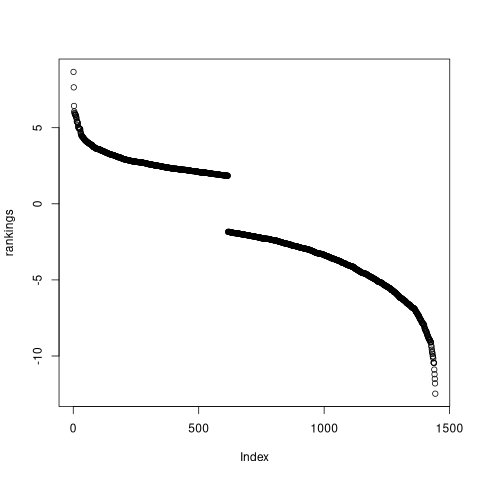

In [61]:
%%R

plot(rankings)

In [62]:
%%R

max(rankings)

[1] 8.665737


In [63]:
%%R

min(rankings)

[1] -12.47622


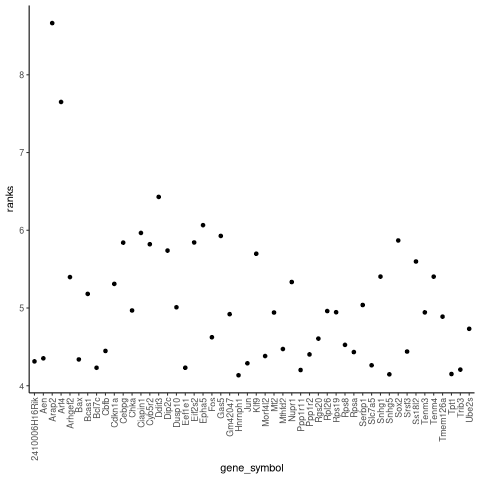

In [64]:
%%R

ggplot(data.frame(gene_symbol = names(rankings)[1:50], ranks = rankings[1:50]), aes(gene_symbol, ranks)) + 
    geom_point() +
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Set up gene lists

In [65]:
%%R
fgsea_res <- fgsea(pathways = pathwaysH, 
                  stats    = rankings,
                  scoreType = 'std',
                  minSize  = 15,
                  maxSize  = 500)

In [66]:
%%R
fgsea_res

                                       pathway         pval         padj
                                        <char>        <num>        <num>
 1:                      HALLMARK_ADIPOGENESIS 2.284024e-01 3.654438e-01
 2:               HALLMARK_ALLOGRAFT_REJECTION 4.413408e-01 5.296089e-01
 3:                 HALLMARK_ANDROGEN_RESPONSE 4.940048e-01 5.645769e-01
 4:                   HALLMARK_APICAL_JUNCTION 3.237410e-02 9.165005e-02
 5:                         HALLMARK_APOPTOSIS 1.082856e-01 2.165712e-01
 6:                       HALLMARK_E2F_TARGETS 1.347736e-02 6.469133e-02
 7: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 7.002488e-01 7.639077e-01
 8:                    HALLMARK_G2M_CHECKPOINT 1.592357e-01 2.939735e-01
 9:                        HALLMARK_GLYCOLYSIS 7.717528e-01 8.053073e-01
10:                   HALLMARK_HEME_METABOLISM 3.593023e-01 5.072503e-01
11:               HALLMARK_IL2_STAT5_SIGNALING 4.280576e-01 5.296089e-01
12:                 HALLMARK_KRAS_SIGNALING_UP 6.05

In [67]:
%%R

dim(fgsea_res)

[1] 24  8


In [68]:
%%R

fwrite(fgsea_res, file = "./files/fgsea_Cupr_demyel_MOL_G_all.csv")

In [69]:
%%R

# Filter for significant results with padj < 0.05
fgsea_MOL4_significant <- fgsea_res %>% filter(padj < 0.1)
dim(fgsea_MOL4_significant)

[1] 9 8


In [70]:
%%R

head(fgsea_MOL4_significant)

                              pathway         pval         padj   log2err
                               <char>        <num>        <num>     <num>
1:           HALLMARK_APICAL_JUNCTION 3.237410e-02 9.165005e-02 0.2765006
2:               HALLMARK_E2F_TARGETS 1.347736e-02 6.469133e-02 0.3807304
3:          HALLMARK_MTORC1_SIGNALING 4.372946e-04 2.623768e-03 0.4984931
4:            HALLMARK_MYC_TARGETS_V1 2.553357e-18 6.128056e-17 1.1053366
5: HALLMARK_OXIDATIVE_PHOSPHORYLATION 1.978022e-04 1.582418e-03 0.5188481
6:               HALLMARK_P53_PATHWAY 3.720035e-06 4.464042e-05 0.6272567
           ES       NES  size                                 leadingEdge
        <num>     <num> <int>                                      <list>
1: -0.4418007 -1.595641    22   Ppp2r2c,Gamt,Itgb4,Insig1,Ptk2,Cldn11,...
2:  0.3697450  1.960209    21    Cdkn1a,Ube2s,Mthfd2,Nasp,Pole4,Phf5a,...
3:  0.3489406  2.244113    37 Ddit3,Eif2s2,Nupr1,Cdkn1a,Mthfd2,Slc7a5,...
4:  0.6273381  4.623580    53 Eif2s2,S

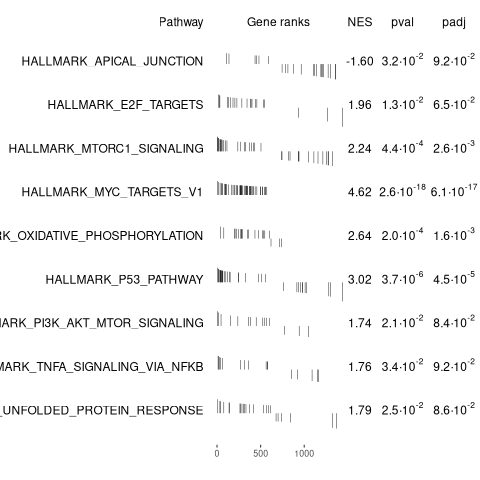

In [71]:
%%R

plotGseaTable(pathwaysH[fgsea_MOL4_significant$pathway], 
              rankings, 
              fgsea_MOL4_significant, 
              gseaParam = 0.5)

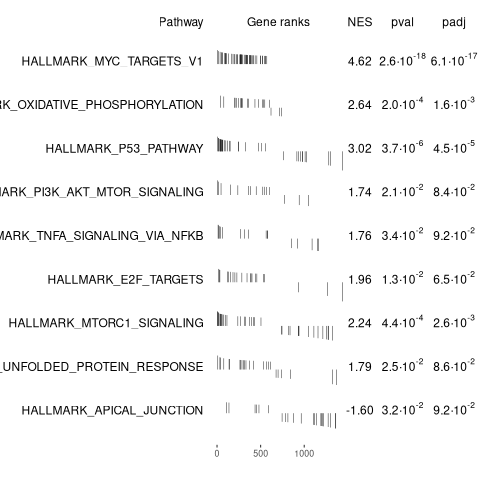

In [72]:
%%R

topUp <- fgsea_MOL4_significant %>% 
    filter(ES > 0) %>% 
    top_n(10, wt=-padj)

topDown <- fgsea_MOL4_significant %>% 
    filter(ES < 0) %>% 
    top_n(10, wt=-padj)

topPathways <- bind_rows(topUp, topDown) %>% 
    arrange(-ES)

plotGseaTable(pathwaysH[topPathways$pathway], 
              rankings, 
              fgsea_MOL4_significant, 
              gseaParam = 0.5)

In [73]:
%%R

collapsedPathways <- collapsePathways(fgsea_MOL4_significant[order(pval)][padj < 0.05], 
                                      pathwaysH, rankings)

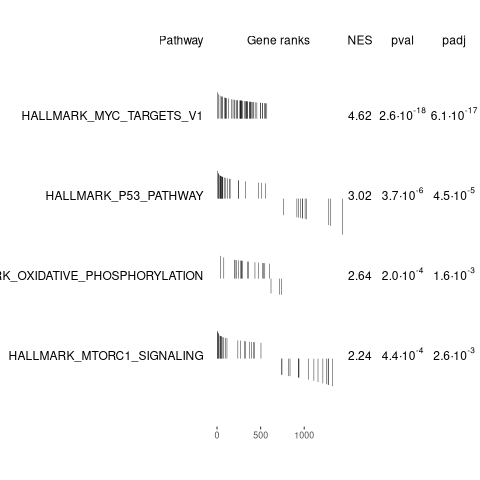

In [74]:
%%R

mainPathways <- fgsea_MOL4_significant[pathway %in% collapsedPathways$mainPathways][
                         order(-NES), pathway]
plotGseaTable(pathwaysH[mainPathways], rankings, fgsea_MOL4_significant, 
              gseaParam = 0.5)

In [75]:
%%R

fgseaResTidy <- fgsea_res %>%
  as_tibble() %>%
  arrange(desc(NES))

In [76]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.05, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 4 × 4
  pathway                                padj   NES  size
  <chr>                                 <dbl> <dbl> <int>
1 HALLMARK_MYC_TARGETS_V1            6.13e-17  4.62    53
2 HALLMARK_P53_PATHWAY               4.46e- 5  3.02    35
3 HALLMARK_OXIDATIVE_PHOSPHORYLATION 1.58e- 3  2.64    21
4 HALLMARK_MTORC1_SIGNALING          2.62e- 3  2.24    37


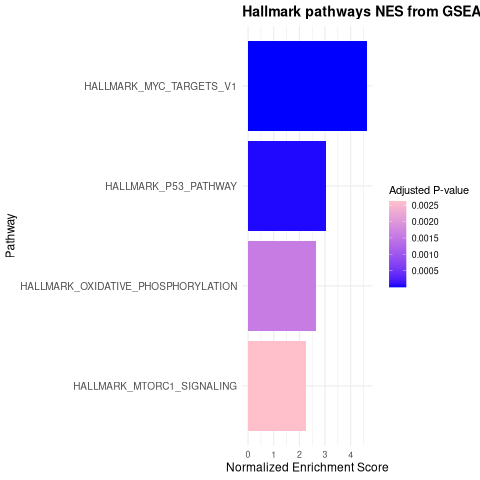

In [77]:
%%R

# Create the ggplot with a color scale for padj
ggplot(fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "blue", high = "pink", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

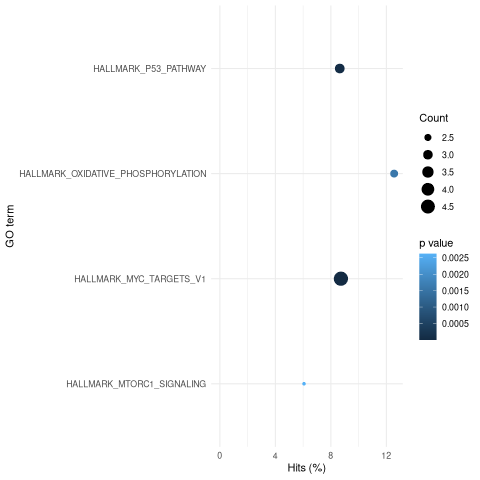

In [78]:
%%R

# Calculate hits percentage (if 'numDEInCat' and 'numInCat' equivalent are 'NES' and 'size')
fgseaResSignificant <- fgseaResSignificant %>%
  mutate(hitsPerc = NES * 100 / size)

# Ensure the columns 'padj' and 'NES' are present for the plot
fgseaResSignificant <- fgseaResSignificant %>%
  rename(term = pathway, over_represented_pvalue = padj, numDEInCat = NES)

# Create the plot
ggplot(fgseaResSignificant, aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
  geom_point() +
  expand_limits(x = 0) +
  labs(x = "Hits (%)", y = "GO term", colour = "p value", size = "Count") +
  theme_minimal()

#https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2018/RNASeq2018/html/06_Gene_set_testing.nb.html

In [79]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.05, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 4 × 4
  pathway                                padj   NES  size
  <chr>                                 <dbl> <dbl> <int>
1 HALLMARK_MYC_TARGETS_V1            6.13e-17  4.62    53
2 HALLMARK_P53_PATHWAY               4.46e- 5  3.02    35
3 HALLMARK_OXIDATIVE_PHOSPHORYLATION 1.58e- 3  2.64    21
4 HALLMARK_MTORC1_SIGNALING          2.62e- 3  2.24    37


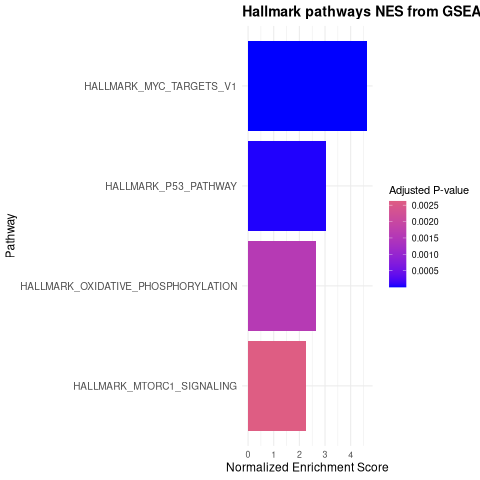

In [80]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgseaResSignificant <- fgseaResSignificant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Create the ggplot with a color scale for padj
ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )


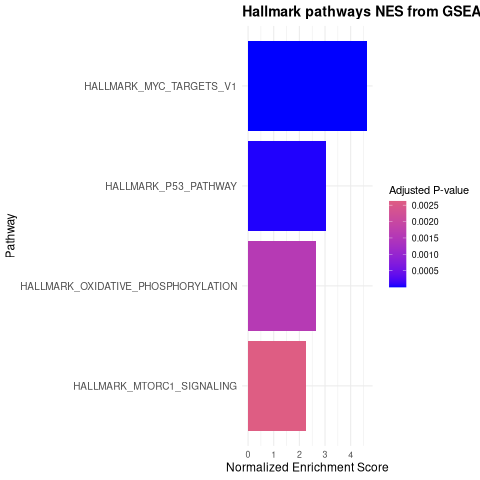

In [81]:
%%R

# Create the ggplot
plot <- # Create the ggplot with a color scale for padj
ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

# Save the plot as a high-resolution PNG file
#ggsave("./figures/GSEA/Cupr_demyel_MOL_G_reduced_hallmark_pathways_NES_GSEA.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

In [82]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
filtered_fgseaResSignificant$pathway <- gsub("^HALLMARK_", "", filtered_fgseaResSignificant$pathway)

# View the updated heatmap_df
head(filtered_fgseaResSignificant)

# A tibble: 4 × 4
  pathway                       padj   NES  size
  <chr>                        <dbl> <dbl> <int>
1 MYC_TARGETS_V1            6.13e-17  4.62    53
2 P53_PATHWAY               4.46e- 5  3.02    35
3 OXIDATIVE_PHOSPHORYLATION 1.58e- 3  2.64    21
4 MTORC1_SIGNALING          2.62e- 3  2.24    37


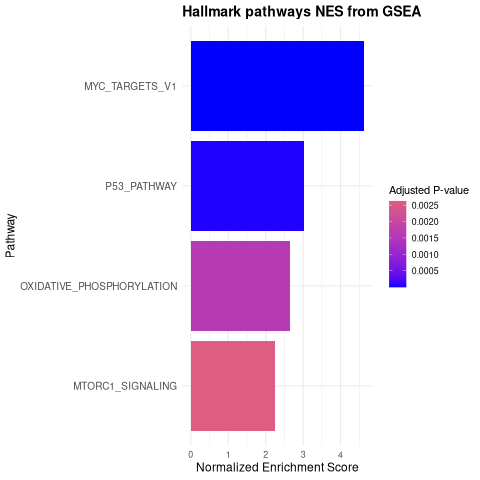

In [83]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

# Save the plot as a high-resolution PNG file
#ggsave("./figures/GSEA/LPC_remyel_MOL_hallmark_pathways_NES_GSEA_trimmed.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

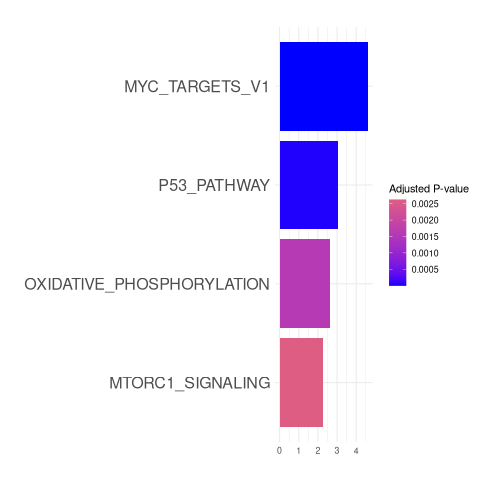

In [84]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "", y = "",
       title = "") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 16),
    axis.title = element_text(size = 16),
    plot.title = element_text(size = 16, face = "bold")
  )

# Save the plot as a high-resolution PNG file
ggsave("./figures/GSEA/Cupr_demyel_MOL_G_reduced_hallmark_pathways_NES_GSEA_trimmed.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

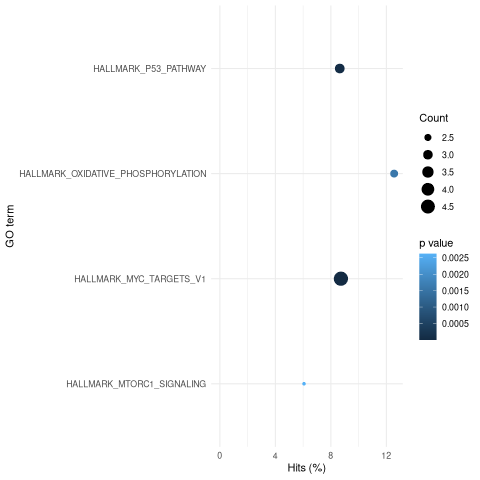

In [85]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgseaResSignificant <- fgseaResSignificant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Calculate hits percentage
filtered_fgseaResSignificant <- filtered_fgseaResSignificant %>%
  mutate(hitsPerc = NES * 100 / size)

# Ensure the columns 'padj' and 'NES' are present for the plot
filtered_fgseaResSignificant <- filtered_fgseaResSignificant %>%
  rename(term = pathway, over_represented_pvalue = padj, numDEInCat = NES)

# Create the plot
ggplot(filtered_fgseaResSignificant, aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
  geom_point() +
  expand_limits(x = 0) +
  labs(x = "Hits (%)", y = "GO term", colour = "p value", size = "Count") +
  theme_minimal()


In [86]:
%%R

filtered_fgseaResSignificant_LPC_remyel <- fgsea_MOL4_significant
# Remove "HALLMARK_" prefix from the 'pathway' column
filtered_fgseaResSignificant_LPC_remyel$pathway <- gsub("^HALLMARK_", "", filtered_fgseaResSignificant_LPC_remyel$pathway)
head(filtered_fgseaResSignificant_LPC_remyel)

                     pathway         pval         padj   log2err         ES
                      <char>        <num>        <num>     <num>      <num>
1:           APICAL_JUNCTION 3.237410e-02 9.165005e-02 0.2765006 -0.4418007
2:               E2F_TARGETS 1.347736e-02 6.469133e-02 0.3807304  0.3697450
3:          MTORC1_SIGNALING 4.372946e-04 2.623768e-03 0.4984931  0.3489406
4:            MYC_TARGETS_V1 2.553357e-18 6.128056e-17 1.1053366  0.6273381
5: OXIDATIVE_PHOSPHORYLATION 1.978022e-04 1.582418e-03 0.5188481  0.4975013
6:               P53_PATHWAY 3.720035e-06 4.464042e-05 0.6272567  0.4575375
         NES  size                                 leadingEdge
       <num> <int>                                      <list>
1: -1.595641    22   Ppp2r2c,Gamt,Itgb4,Insig1,Ptk2,Cldn11,...
2:  1.960209    21    Cdkn1a,Ube2s,Mthfd2,Nasp,Pole4,Phf5a,...
3:  2.244113    37 Ddit3,Eif2s2,Nupr1,Cdkn1a,Mthfd2,Slc7a5,...
4:  4.623580    53 Eif2s2,Serbp1,Srsf3,Ifrd1,Ube2e1,Hnrnpc,...
5:  2.637510  

In [87]:
%%R
unique(filtered_fgseaResSignificant_LPC_remyel$pathway)

[1] "APICAL_JUNCTION"           "E2F_TARGETS"              
[3] "MTORC1_SIGNALING"          "MYC_TARGETS_V1"           
[5] "OXIDATIVE_PHOSPHORYLATION" "P53_PATHWAY"              
[7] "PI3K_AKT_MTOR_SIGNALING"   "TNFA_SIGNALING_VIA_NFKB"  
[9] "UNFOLDED_PROTEIN_RESPONSE"


In [88]:
%%R

# Define the pathway of interest
pathway_of_interest <- "TNFA_SIGNALING_VIA_NFKB"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_remyel[filtered_fgseaResSignificant_LPC_remyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

[1] "Klf9"    "Cdkn1a"  "Fos"     "Jun"     "Gadd45a"


In [89]:
%%R

# Define the pathway of interest
pathway_of_interest <- "INTERFERON_ALPHA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_remyel[filtered_fgseaResSignificant_LPC_remyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [90]:
%%R

# Define the pathway of interest
pathway_of_interest <- "INTERFERON_GAMMA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_remyel[filtered_fgseaResSignificant_LPC_remyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [91]:
%%R

# Define the pathway of interest
pathway_of_interest <- "IL6_JAK_STAT3_SIGNALING"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_remyel[filtered_fgseaResSignificant_LPC_remyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [92]:
%%R

# Define the pathway of interest
pathway_of_interest <- "INFLAMMATORY_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_remyel[filtered_fgseaResSignificant_LPC_remyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [93]:
%%R

# Define the pathway of interest
pathway_of_interest <- "CHOLESTEROL_HOMEOSTASIS"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_remyel[filtered_fgseaResSignificant_LPC_remyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [94]:
%%R

# Define the pathway of interest
pathway_of_interest <- "ESTROGEN_RESPONSE_LATE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_remyel[filtered_fgseaResSignificant_LPC_remyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [95]:
%%R

# Define the pathway of interest
pathway_of_interest <- "P53_PATHWAY"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgseaResSignificant_LPC_remyel[filtered_fgseaResSignificant_LPC_remyel$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "Ddit3"   "Nupr1"   "Cdkn1a"  "Fos"     "Aen"     "Bax"     "Jun"    
 [8] "Trib3"   "Rps12"   "Phlda3"  "Rps27l"  "Gadd45a" "Ccng1"   "Rack1"  
[15] "Rpl18"   "Slc3a2"  "Zmat3"   "Hint1"  


In [96]:
%%R

class(fgsea_MOL4_significant)

[1] "data.table" "data.frame"


In [97]:
%%R

fgsea_MOL4_significant <- as.data.frame(fgsea_MOL4_significant)

In [98]:
%%R
library(data.table)
fwrite(fgsea_MOL4_significant, file = "./files/filtered_fgseaResSignificant_Cupr_demyel_MOL_G_NEW.csv")

# Combined dot plot

In [99]:
%%R

# Load the data.table package
library(data.table)

# Read the files back into R
OPC_de <- fread("./files/filtered_fgseaResSignificant_LPC_demyel_OPC_NEW.csv")
LPC_de_F <- fread("./files/filtered_fgseaResSignificant_LPC_demyel_MOL_F_NEW.csv")
LPC_de_E <- fread("./files/filtered_fgseaResSignificant_LPC_demyel_MOL_E_NEW.csv")
LPC_re_E <- fread("./files/filtered_fgseaResSignificant_LPC_remyel_MOL_E_NEW.csv")
Cupr_de_G <- fread("./files/filtered_fgseaResSignificant_Cupr_demyel_MOL_G_NEW.csv")
#Cupr_re_E <- fread("./files/filtered_fgseaResSignificant_Cupr_remyel_MOL_E.csv")

In [100]:
%%R

# Subset the data frames to include only pathway, padj, NES, and size
subset_columns <- c("pathway", "NES", "padj")

#OPC_de_subset <- OPC_de[, ..subset_columns]
OPC_de_subset <- OPC_de[, ..subset_columns]
LPC_de_F_subset <- LPC_de_F[, ..subset_columns]
LPC_de_E_subset <- LPC_de_E[, ..subset_columns]
LPC_re_E_subset <- LPC_re_E[, ..subset_columns]
Cupr_de_G_subset <- Cupr_de_G[, ..subset_columns]
#Cupr_re_E_subset <- Cupr_re_E[, ..subset_columns]

In [101]:
%%R

# Combine the 'pathway' columns from all the data frames
all_pathways <- unique(c(OPC_de$pathway, LPC_de_F$pathway, LPC_de_E$pathway,
                        LPC_re_E$pathway, Cupr_de_G$pathway))

# Verify the unique pathways
print(head(all_pathways))

# Check the total number of unique pathways
length(all_pathways)

[1] "APOPTOSIS"                 "DNA_REPAIR"               
[3] "E2F_TARGETS"               "INTERFERON_GAMMA_RESPONSE"
[5] "KRAS_SIGNALING_UP"         "MTORC1_SIGNALING"         
[1] 32


In [102]:
%%R
# Function to ensure each data frame includes all pathways and fills missing ones with NaN
fill_missing_pathways <- function(df, all_pathways) {
  # Identify pathways that are missing in the current data frame
  missing_pathways <- setdiff(all_pathways, df$pathway)
  
  # Create a data frame with missing pathways, NES and padj set to NaN
  missing_data <- data.frame(pathway = missing_pathways, 
                             NES = rep(NaN, length(missing_pathways)), 
                             padj = rep(NaN, length(missing_pathways)))
  
  # Combine the original data frame with the missing pathways
  df <- rbind(df[, c("pathway", "NES", "padj")], missing_data)
  
  # Sort by pathway to maintain a consistent order
  df <- df[order(df$pathway), ]
  
  return(df)
}

# List of all unique pathways
all_pathways <- unique(c(OPC_de$pathway, LPC_de_F$pathway, LPC_de_E$pathway,
                        LPC_re_E$pathway, Cupr_de_G$pathway))

# Apply the function to all data frames
OPC_de_filtered <- fill_missing_pathways(OPC_de_subset, all_pathways)
LPC_de_F_filtered <- fill_missing_pathways(LPC_de_F_subset, all_pathways)
LPC_de_E_filtered <- fill_missing_pathways(LPC_de_E_subset, all_pathways)
LPC_re_E_filtered <- fill_missing_pathways(LPC_re_E_subset, all_pathways)
Cupr_de_G_filtered <- fill_missing_pathways(Cupr_de_G_subset, all_pathways)
#Cupr_re_E_filtered <- fill_missing_pathways(Cupr_re_E_subset, all_pathways)

In [103]:
%%R

head(Cupr_de_G_filtered)

                    pathway       NES       padj
                     <char>     <num>      <num>
1:                APOPTOSIS       NaN        NaN
2:               DNA_REPAIR       NaN        NaN
3:              E2F_TARGETS       NaN        NaN
4: HALLMARK_APICAL_JUNCTION -1.595641 0.09165005
5:       HALLMARK_APOPTOSIS       NaN        NaN
6:     HALLMARK_COAGULATION       NaN        NaN


In [104]:
%%R

OPC_de_filtered$condition <- "LPC_de_OPC"
LPC_de_F_filtered$condition <- "LPC_de_MOL_F"
LPC_de_E_filtered$condition <- "LPC_de_MOL_E"
LPC_re_E_filtered$condition <- "LPC_re_MOL_E"
Cupr_de_G_filtered$condition <- "Cupr_de_MOL_G"
#Cupr_re_E_filtered$condition <- "Cupr_re_MOL_E"

# Combine all datasets into a single dataframe
combined_df <- rbind(OPC_de_filtered, LPC_de_F_filtered, LPC_de_E_filtered,
                    LPC_re_E_filtered, Cupr_de_G_filtered)

# Verify the structure
head(combined_df)

                    pathway      NES         padj  condition
                     <char>    <num>        <num>     <char>
1:                APOPTOSIS 2.404874 0.0009029262 LPC_de_OPC
2:               DNA_REPAIR 1.862395 0.0461685217 LPC_de_OPC
3:              E2F_TARGETS 2.469246 0.0006370238 LPC_de_OPC
4: HALLMARK_APICAL_JUNCTION      NaN          NaN LPC_de_OPC
5:       HALLMARK_APOPTOSIS      NaN          NaN LPC_de_OPC
6:     HALLMARK_COAGULATION      NaN          NaN LPC_de_OPC


In [105]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
combined_df$pathway <- gsub("^HALLMARK_", "", combined_df$pathway)

# View the updated heatmap_df
head(combined_df)

           pathway      NES         padj  condition
            <char>    <num>        <num>     <char>
1:       APOPTOSIS 2.404874 0.0009029262 LPC_de_OPC
2:      DNA_REPAIR 1.862395 0.0461685217 LPC_de_OPC
3:     E2F_TARGETS 2.469246 0.0006370238 LPC_de_OPC
4: APICAL_JUNCTION      NaN          NaN LPC_de_OPC
5:       APOPTOSIS      NaN          NaN LPC_de_OPC
6:     COAGULATION      NaN          NaN LPC_de_OPC


In [106]:
%%R

# Transform padj to -log10 for better visualization
combined_df$log_padj <- -log10(combined_df$padj)

In addition: Warning message:
Removed 116 rows containing missing values or values outside the scale range
(`geom_point()`). 


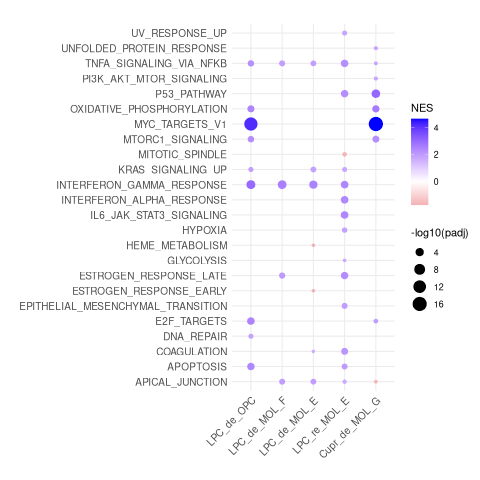

In [107]:
%%R

library(ggplot2)

# Set the factor levels for conditions to control the order
combined_df$condition <- factor(combined_df$condition, 
                                 levels = c("LPC_de_OPC", "LPC_de_MOL_F", "LPC_de_MOL_E",
                                           "LPC_re_MOL_E", "Cupr_de_MOL_G"))

# Create the dotplot with switched axes and assign to heatmap_plot
heatmap_plot <- ggplot(combined_df, aes(y = pathway, x = condition, size = log_padj, color = NES)) +
  geom_point() +
  scale_color_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 10), # Adjust pathway text size for readability
        axis.text.x = element_text(angle = 45, hjust = 1, size = 10)) + # Adjust condition text
  labs(x = "", y = "", 
       size = "-log10(padj)", color = "NES", 
       title = "")

# Show the plot
print(heatmap_plot)

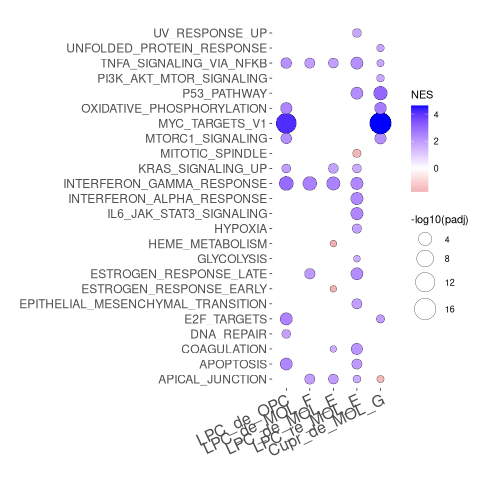

In [108]:
%%R

# Remove rows with missing or NaN values in `log_padj` or `NES`
filtered_df <- combined_df[!is.na(combined_df$log_padj) & !is.na(combined_df$NES), ]

# Set the factor levels for conditions to control the order
combined_df$condition <- factor(combined_df$condition, 
                                 levels = c("LPC_de_OPC", "LPC_de_MOL_F", "LPC_de_MOL_E",
                                           "LPC_re_MOL_E", "Cupr_de_MOL_G", "Cupr_re_MOL_E"))

# Create the dotplot with adjustments
heatmap_plot <- ggplot(filtered_df, aes(y = pathway, x = condition, size = log_padj, fill = NES)) +
  geom_point(shape = 21, stroke = 0.2, color = "black") + # Add thin black outline to dots
  scale_fill_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  scale_size_continuous(range = c(3, 10)) + # Increase size of dots (min=3, max=10)
  theme_minimal() +
  theme(
    panel.grid = element_blank(), # Remove grid lines
    axis.text.y = element_text(size = 12), # Adjust pathway text size
    axis.text.x = element_text(angle = 25, hjust = 1, size = 16, vjust = 1), # Adjust x-axis text spacing
    axis.ticks = element_line(linewidth = 0.3) # Adjust x-axis ticks with `linewidth`
  ) +
  labs(
    x = "", 
    y = "", 
    size = "-log10(padj)", 
    fill = "NES", 
    title = ""
  )

# Display the plot
print(heatmap_plot)

# Save the plot
ggsave("./figures/GSEA/heatmap_pathway_NES_padj_ALL_only.png", plot = heatmap_plot, dpi = 300, width = 10, height = 8)

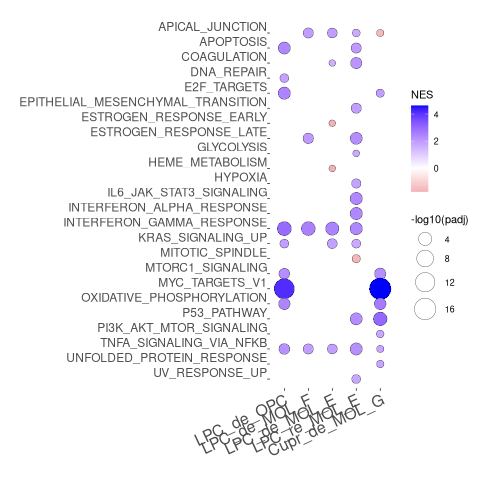

In [109]:
%%R

# Create the dotplot with adjustments
heatmap_plot <- ggplot(filtered_df, aes(y = pathway, x = condition, size = log_padj, fill = NES)) +
  geom_point(shape = 21, stroke = 0.2, color = "black") + # Add thin black outline to dots
  scale_fill_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  scale_size_continuous(range = c(3, 10)) + # Increase size of dots (min=3, max=10)
  scale_y_discrete(limits = rev(levels(factor(filtered_df$pathway))),  # Reverse the y-axis order if needed
                   labels = function(x) paste0(x, "\n")) + # Add line breaks for extra vertical space
  theme_minimal() +
  theme(
    panel.grid = element_blank(), # Remove grid lines
    axis.text.y = element_text(size = 12, margin = margin(t = 5, b = 5)), # Add vertical spacing for y-axis text
    axis.text.x = element_text(angle = 25, hjust = 1, size = 16, vjust = 1), # Adjust x-axis text spacing
    axis.ticks = element_line(linewidth = 0.3) # Adjust x-axis ticks with `linewidth`
  ) +
  labs(
    x = "", 
    y = "", 
    size = "-log10(padj)", 
    fill = "NES", 
    title = ""
  )

# Display the plot
print(heatmap_plot)

# Save the plot
ggsave("./figures/GSEA/heatmap_pathway_NES_padj_ALL_only.png", plot = heatmap_plot, dpi = 300, width = 10, height = 8)

# Without OPC:

In [172]:
%%R

# Load the data.table package
library(data.table)

# Read the files back into R
#OPC_de <- fread("./files/filtered_fgseaResSignificant_LPC_demyel_OPC_NEW.csv")
LPC_de_F <- fread("./files/filtered_fgseaResSignificant_LPC_demyel_MOL_F_NEW.csv")
LPC_de_E <- fread("./files/filtered_fgseaResSignificant_LPC_demyel_MOL_E_NEW.csv")
LPC_re_E <- fread("./files/filtered_fgseaResSignificant_LPC_remyel_MOL_E_NEW.csv")
Cupr_de_G <- fread("./files/filtered_fgseaResSignificant_Cupr_demyel_MOL_G_NEW.csv")
#Cupr_re_E <- fread("./files/filtered_fgseaResSignificant_Cupr_remyel_MOL_E.csv")

In [173]:
%%R

# Subset the data frames to include only pathway, padj, NES, and size
subset_columns <- c("pathway", "NES", "padj")

#OPC_de_subset <- OPC_de[, ..subset_columns]
#OPC_de_subset <- OPC_de[, ..subset_columns]
LPC_de_F_subset <- LPC_de_F[, ..subset_columns]
LPC_de_E_subset <- LPC_de_E[, ..subset_columns]
LPC_re_E_subset <- LPC_re_E[, ..subset_columns]
Cupr_de_G_subset <- Cupr_de_G[, ..subset_columns]
#Cupr_re_E_subset <- Cupr_re_E[, ..subset_columns]

In [174]:
%%R

# Combine the 'pathway' columns from all the data frames
all_pathways <- unique(c(LPC_de_F$pathway, LPC_de_E$pathway,
                        LPC_re_E$pathway, Cupr_de_G$pathway))

# Verify the unique pathways
print(head(all_pathways))

# Check the total number of unique pathways
length(all_pathways)

[1] "HALLMARK_APICAL_JUNCTION"           "HALLMARK_ESTROGEN_RESPONSE_LATE"   
[3] "HALLMARK_INTERFERON_GAMMA_RESPONSE" "HALLMARK_TNFA_SIGNALING_VIA_NFKB"  
[5] "HALLMARK_COAGULATION"               "HALLMARK_ESTROGEN_RESPONSE_EARLY"  
[1] 23


In [175]:
%%R
# Function to ensure each data frame includes all pathways and fills missing ones with NaN
fill_missing_pathways <- function(df, all_pathways) {
  # Identify pathways that are missing in the current data frame
  missing_pathways <- setdiff(all_pathways, df$pathway)
  
  # Create a data frame with missing pathways, NES and padj set to NaN
  missing_data <- data.frame(pathway = missing_pathways, 
                             NES = rep(NaN, length(missing_pathways)), 
                             padj = rep(NaN, length(missing_pathways)))
  
  # Combine the original data frame with the missing pathways
  df <- rbind(df[, c("pathway", "NES", "padj")], missing_data)
  
  # Sort by pathway to maintain a consistent order
  df <- df[order(df$pathway), ]
  
  return(df)
}

# List of all unique pathways
all_pathways <- unique(c(LPC_de_F$pathway, LPC_de_E$pathway,
                        LPC_re_E$pathway, Cupr_de_G$pathway))

# Apply the function to all data frames
#OPC_de_filtered <- fill_missing_pathways(OPC_de_subset, all_pathways)
LPC_de_F_filtered <- fill_missing_pathways(LPC_de_F_subset, all_pathways)
LPC_de_E_filtered <- fill_missing_pathways(LPC_de_E_subset, all_pathways)
LPC_re_E_filtered <- fill_missing_pathways(LPC_re_E_subset, all_pathways)
Cupr_de_G_filtered <- fill_missing_pathways(Cupr_de_G_subset, all_pathways)
#Cupr_re_E_filtered <- fill_missing_pathways(Cupr_re_E_subset, all_pathways)

In [176]:
%%R

head(Cupr_de_G_filtered)

                                      pathway       NES       padj
                                       <char>     <num>      <num>
1:                   HALLMARK_APICAL_JUNCTION -1.595641 0.09165005
2:                         HALLMARK_APOPTOSIS       NaN        NaN
3:                       HALLMARK_COAGULATION       NaN        NaN
4:                       HALLMARK_E2F_TARGETS  1.960209 0.06469133
5: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION       NaN        NaN
6:           HALLMARK_ESTROGEN_RESPONSE_EARLY       NaN        NaN


In [177]:
%%R

#OPC_de_filtered$condition <- "LPC_de_OPC"
LPC_de_F_filtered$condition <- "LPC_de_MOL_F"
LPC_de_E_filtered$condition <- "LPC_de_MOL_E"
LPC_re_E_filtered$condition <- "LPC_re_MOL_E"
Cupr_de_G_filtered$condition <- "Cupr_de_MOL_G"
#Cupr_re_E_filtered$condition <- "Cupr_re_MOL_E"

# Combine all datasets into a single dataframe
combined_df <- rbind(LPC_de_F_filtered, LPC_de_E_filtered,
                    LPC_re_E_filtered, Cupr_de_G_filtered)

# Verify the structure
head(combined_df)

                                      pathway      NES       padj    condition
                                       <char>    <num>      <num>       <char>
1:                   HALLMARK_APICAL_JUNCTION 1.950714 0.01415599 LPC_de_MOL_F
2:                         HALLMARK_APOPTOSIS      NaN        NaN LPC_de_MOL_F
3:                       HALLMARK_COAGULATION      NaN        NaN LPC_de_MOL_F
4:                       HALLMARK_E2F_TARGETS      NaN        NaN LPC_de_MOL_F
5: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION      NaN        NaN LPC_de_MOL_F
6:           HALLMARK_ESTROGEN_RESPONSE_EARLY      NaN        NaN LPC_de_MOL_F


In [178]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
combined_df$pathway <- gsub("^HALLMARK_", "", combined_df$pathway)

# View the updated heatmap_df
head(combined_df)

                             pathway      NES       padj    condition
                              <char>    <num>      <num>       <char>
1:                   APICAL_JUNCTION 1.950714 0.01415599 LPC_de_MOL_F
2:                         APOPTOSIS      NaN        NaN LPC_de_MOL_F
3:                       COAGULATION      NaN        NaN LPC_de_MOL_F
4:                       E2F_TARGETS      NaN        NaN LPC_de_MOL_F
5: EPITHELIAL_MESENCHYMAL_TRANSITION      NaN        NaN LPC_de_MOL_F
6:           ESTROGEN_RESPONSE_EARLY      NaN        NaN LPC_de_MOL_F


In [179]:
%%R

# Transform padj to -log10 for better visualization
combined_df$log_padj <- -log10(combined_df$padj)

In addition: Warning message:
Removed 57 rows containing missing values or values outside the scale range
(`geom_point()`). 


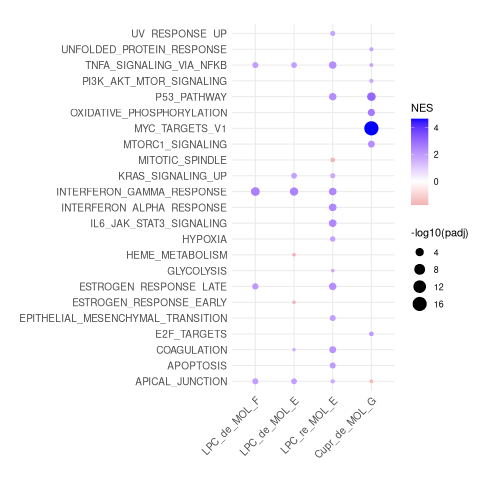

In [180]:
%%R

library(ggplot2)

# Set the factor levels for conditions to control the order
combined_df$condition <- factor(combined_df$condition, 
                                 levels = c("LPC_de_MOL_F", "LPC_de_MOL_E",
                                           "LPC_re_MOL_E", "Cupr_de_MOL_G"))

# Create the dotplot with switched axes and assign to heatmap_plot
heatmap_plot <- ggplot(combined_df, aes(y = pathway, x = condition, size = log_padj, color = NES)) +
  geom_point() +
  scale_color_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 10), # Adjust pathway text size for readability
        axis.text.x = element_text(angle = 45, hjust = 1, size = 10)) + # Adjust condition text
  labs(x = "", y = "", 
       size = "-log10(padj)", color = "NES", 
       title = "")

# Show the plot
print(heatmap_plot)

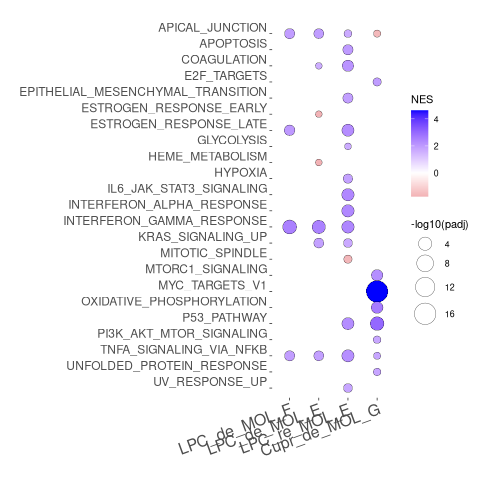

In [181]:
%%R

# Remove rows with missing or NaN values in `log_padj` or `NES`
filtered_df <- combined_df[!is.na(combined_df$log_padj) & !is.na(combined_df$NES), ]

# Set the factor levels for conditions to control the order
combined_df$condition <- factor(combined_df$condition, 
                                 levels = c("LPC_de_MOL_F", "LPC_de_MOL_E",
                                           "LPC_re_MOL_E", "Cupr_de_MOL_G"))


# Create the dotplot with adjustments
heatmap_plot <- ggplot(filtered_df, aes(y = pathway, x = condition, size = log_padj, fill = NES)) +
  geom_point(shape = 21, stroke = 0.2, color = "black") + # Add thin black outline to dots
  scale_fill_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  scale_size_continuous(range = c(3, 10)) + # Increase size of dots (min=3, max=10)
  scale_y_discrete(limits = rev(levels(factor(filtered_df$pathway))),  # Reverse the y-axis order if needed
                   labels = function(x) paste0(x, "\n")) + # Add line breaks for extra vertical space
  theme_minimal() +
  theme(
    panel.grid = element_blank(), # Remove grid lines
    axis.text.y = element_text(size = 12), # Add vertical spacing for y-axis text
    axis.text.x = element_text(angle = 20, hjust = 1, size = 16, vjust = 1), # Adjust x-axis text spacing
    axis.ticks = element_line(linewidth = 0.3) # Adjust x-axis ticks with `linewidth`
  ) +
  labs(
    x = "", 
    y = "", 
    size = "-log10(padj)", 
    fill = "NES", 
    title = ""
  )

# Display the plot
print(heatmap_plot)

# Save the plot
#ggsave("./figures/GSEA/heatmap_pathway_NES_padj_MOL_only.png", plot = heatmap_plot, dpi = 300, width = 10, height = 8)

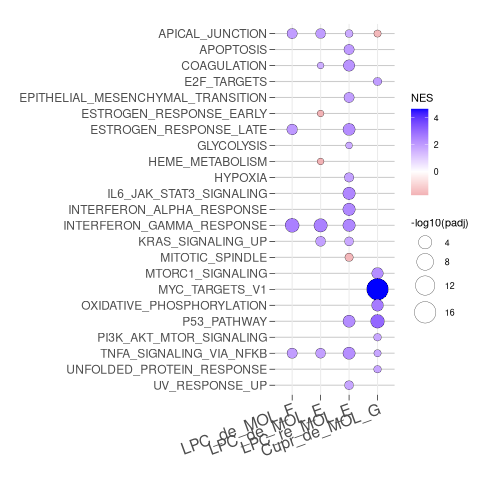

In [182]:
%%R

# Remove rows with missing or NaN values in `log_padj` or `NES`
filtered_df <- combined_df[!is.na(combined_df$log_padj) & !is.na(combined_df$NES), ]

# Set the factor levels for conditions to control the order
filtered_df$condition <- factor(filtered_df$condition, 
                                levels = c("LPC_de_MOL_F", "LPC_de_MOL_E",
                                           "LPC_re_MOL_E", "Cupr_de_MOL_G"))

# Create the dotplot with adjustments
heatmap_plot <- ggplot(filtered_df, aes(y = pathway, x = condition, size = log_padj, fill = NES)) +
  geom_point(shape = 21, stroke = 0.2, color = "black") + # Add thin black outline to dots
  scale_fill_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  scale_size_continuous(range = c(3, 10)) + # Increase size of dots (min=3, max=10)
  scale_y_discrete(limits = rev(levels(factor(filtered_df$pathway)))) + # Reverse y-axis order
  theme_minimal() +
  theme(
    panel.grid.major.y = element_line(color = "grey80", linewidth = 0.5), # Use `linewidth` instead of `size`
    panel.grid.minor = element_blank(), # Remove minor grid lines
    axis.text.y = element_text(size = 12, vjust = 0.5), # Adjust vertical alignment of y-axis text
    axis.text.x = element_text(angle = 20, hjust = 1, size = 16, vjust = 1), # Adjust x-axis text spacing
    axis.ticks = element_line(linewidth = 0.3), # Adjust axis ticks with `linewidth`
    axis.ticks.length = unit(0.2, "cm") # Make ticks slightly longer
  ) +
  labs(
    x = "", 
    y = "", 
    size = "-log10(padj)", 
    fill = "NES", 
    title = ""
  )

# Display the plot
print(heatmap_plot)

# Save the plot
#ggsave("./figures/GSEA/heatmap_pathway_NES_padj_MOL_only.png", plot = heatmap_plot, dpi = 300, width = 10, height = 8)

In [183]:
%%R
print(unique(filtered_df$pathway))

 [1] "APICAL_JUNCTION"                   "ESTROGEN_RESPONSE_LATE"           
 [3] "INTERFERON_GAMMA_RESPONSE"         "TNFA_SIGNALING_VIA_NFKB"          
 [5] "COAGULATION"                       "ESTROGEN_RESPONSE_EARLY"          
 [7] "HEME_METABOLISM"                   "KRAS_SIGNALING_UP"                
 [9] "APOPTOSIS"                         "EPITHELIAL_MESENCHYMAL_TRANSITION"
[11] "GLYCOLYSIS"                        "HYPOXIA"                          
[13] "IL6_JAK_STAT3_SIGNALING"           "INTERFERON_ALPHA_RESPONSE"        
[15] "MITOTIC_SPINDLE"                   "P53_PATHWAY"                      
[17] "UV_RESPONSE_UP"                    "E2F_TARGETS"                      
[19] "MTORC1_SIGNALING"                  "MYC_TARGETS_V1"                   
[21] "OXIDATIVE_PHOSPHORYLATION"         "PI3K_AKT_MTOR_SIGNALING"          
[23] "UNFOLDED_PROTEIN_RESPONSE"        


In [196]:
%%R

# Define the desired order for the "pathways"
desired_pathway_order <- c("TNFA_SIGNALING_VIA_NFKB",
                            "APICAL_JUNCTION",
                            "INTERFERON_GAMMA_RESPONSE",
                           "KRAS_SIGNALING_UP",
                            "COAGULATION",
                            "ESTROGEN_RESPONSE_LATE",
                            "P53_PATHWAY",
                            "ESTROGEN_RESPONSE_EARLY",
                            "HEME_METABOLISM",
                            "INTERFERON_ALPHA_RESPONSE",
                            "IL6_JAK_STAT3_SIGNALING",
                            "EPITHELIAL_MESENCHYMAL_TRANSITION",
                           "APOPTOSIS",
                           "HYPOXIA",
                            "UV_RESPONSE_UP",
                           "GLYCOLYSIS",
                            "MITOTIC_SPINDLE",
                            "MYC_TARGETS_V1",
                            "MTORC1_SIGNALING",
                            "OXIDATIVE_PHOSPHORYLATION",
                            "E2F_TARGETS",
                            "PI3K_AKT_MTOR_SIGNALING",
                            "UNFOLDED_PROTEIN_RESPONSE")

# Reorder the 'pathway' column in filtered_df
filtered_df$pathway <- factor(filtered_df$pathway, levels = desired_pathway_order)

# Verify the order
print(levels(filtered_df$pathway))

 [1] "TNFA_SIGNALING_VIA_NFKB"           "APICAL_JUNCTION"                  
 [3] "INTERFERON_GAMMA_RESPONSE"         "KRAS_SIGNALING_UP"                
 [5] "COAGULATION"                       "ESTROGEN_RESPONSE_LATE"           
 [7] "P53_PATHWAY"                       "ESTROGEN_RESPONSE_EARLY"          
 [9] "HEME_METABOLISM"                   "INTERFERON_ALPHA_RESPONSE"        
[11] "IL6_JAK_STAT3_SIGNALING"           "EPITHELIAL_MESENCHYMAL_TRANSITION"
[13] "APOPTOSIS"                         "HYPOXIA"                          
[15] "UV_RESPONSE_UP"                    "GLYCOLYSIS"                       
[17] "MITOTIC_SPINDLE"                   "MYC_TARGETS_V1"                   
[19] "MTORC1_SIGNALING"                  "OXIDATIVE_PHOSPHORYLATION"        
[21] "E2F_TARGETS"                       "PI3K_AKT_MTOR_SIGNALING"          
[23] "UNFOLDED_PROTEIN_RESPONSE"        


In [197]:
%%R
# Reverse the desired pathway order
reversed_pathway_order <- rev(desired_pathway_order)

# Reorder the 'pathway' column in filtered_df
filtered_df$pathway <- factor(filtered_df$pathway, levels = reversed_pathway_order)

# Verify the reversed order
print(levels(filtered_df$pathway))

 [1] "UNFOLDED_PROTEIN_RESPONSE"         "PI3K_AKT_MTOR_SIGNALING"          
 [3] "E2F_TARGETS"                       "OXIDATIVE_PHOSPHORYLATION"        
 [5] "MTORC1_SIGNALING"                  "MYC_TARGETS_V1"                   
 [7] "MITOTIC_SPINDLE"                   "GLYCOLYSIS"                       
 [9] "UV_RESPONSE_UP"                    "HYPOXIA"                          
[11] "APOPTOSIS"                         "EPITHELIAL_MESENCHYMAL_TRANSITION"
[13] "IL6_JAK_STAT3_SIGNALING"           "INTERFERON_ALPHA_RESPONSE"        
[15] "HEME_METABOLISM"                   "ESTROGEN_RESPONSE_EARLY"          
[17] "P53_PATHWAY"                       "ESTROGEN_RESPONSE_LATE"           
[19] "COAGULATION"                       "KRAS_SIGNALING_UP"                
[21] "INTERFERON_GAMMA_RESPONSE"         "APICAL_JUNCTION"                  
[23] "TNFA_SIGNALING_VIA_NFKB"          


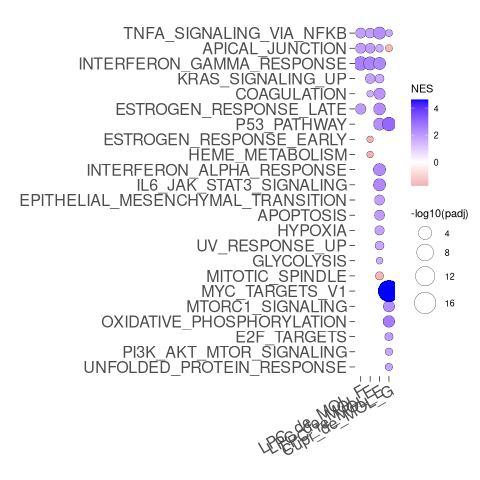

In [198]:
%%R

heatmap_plot <- ggplot(filtered_df, aes(y = pathway, x = condition, size = log_padj, fill = NES)) +
  geom_point(shape = 21, stroke = 0.2, color = "black") +
  scale_fill_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  scale_size_continuous(range = c(3, 10)) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.y = element_text(size = 16, vjust = 0.5),
    axis.text.x = element_text(angle = 30, hjust = 1, size = 16, vjust = 1),
    axis.ticks = element_line(linewidth = 0.3),
    axis.ticks.length = unit(0.2, "cm")
  ) +
  labs(
    x = "", 
    y = "", 
    size = "-log10(padj)", 
    fill = "NES", 
    title = ""
  )

print(heatmap_plot)

ggsave("./figures/GSEA/heatmap_pathway_NES_padj_MOL_only_ordered.png", plot = heatmap_plot, dpi = 300, width = 10, height = 8)

 [1] "Unfolded Protein Response"         "PI3K/AKT/mTOR Signaling"          
 [3] "E2F Targets"                       "Oxidative Phosphorylation"        
 [5] "mTORC1 Signaling"                  "MYC Targets V1"                   
 [7] "Mitotic Spindle"                   "Glycolysis"                       
 [9] "UV Response (Up)"                  "Hypoxia"                          
[11] "Apoptosis"                         "Epithelial-Mesenchymal Transition"
[13] "IL-6/JAK/STAT3 Signaling"          "Interferon-α Response"            
[15] "Heme Metabolism"                   "Estrogen Response (Early)"        
[17] "p53 Pathway"                       "Estrogen Response (Late)"         
[19] "Coagulation"                       "KRAS Signaling (Up)"              
[21] "Interferon-γ Response"             "Apical Junction"                  
[23] "TNFα Signaling via NF-κB"         


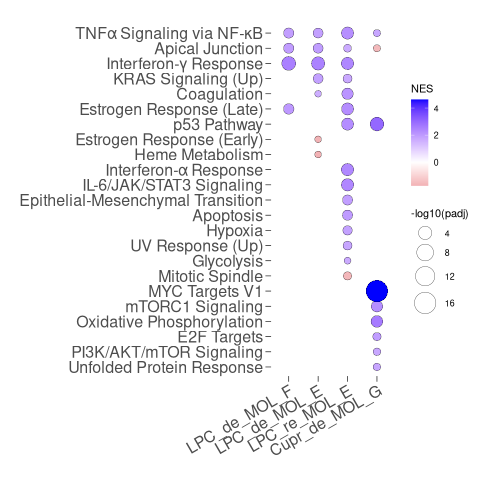

In [199]:
%%R

pathway_name_format <- c(
    "TNFA_SIGNALING_VIA_NFKB" = "TNFα Signaling via NF-κB",
    "APICAL_JUNCTION" = "Apical Junction",
    "INTERFERON_GAMMA_RESPONSE" = "Interferon-γ Response",
    "KRAS_SIGNALING_UP" = "KRAS Signaling (Up)",
    "COAGULATION" = "Coagulation",
    "ESTROGEN_RESPONSE_LATE" = "Estrogen Response (Late)",
    "P53_PATHWAY" = "p53 Pathway",
    "ESTROGEN_RESPONSE_EARLY" = "Estrogen Response (Early)",
    "HEME_METABOLISM" = "Heme Metabolism",
    "INTERFERON_ALPHA_RESPONSE" = "Interferon-α Response",
    "IL6_JAK_STAT3_SIGNALING" = "IL-6/JAK/STAT3 Signaling",
    "EPITHELIAL_MESENCHYMAL_TRANSITION" = "Epithelial-Mesenchymal Transition",
    "APOPTOSIS" = "Apoptosis",
    "HYPOXIA" = "Hypoxia",
    "UV_RESPONSE_UP" = "UV Response (Up)",
    "GLYCOLYSIS" = "Glycolysis",
    "MITOTIC_SPINDLE" = "Mitotic Spindle",
    "MYC_TARGETS_V1" = "MYC Targets V1",
    "MTORC1_SIGNALING" = "mTORC1 Signaling",
    "OXIDATIVE_PHOSPHORYLATION" = "Oxidative Phosphorylation",
    "E2F_TARGETS" = "E2F Targets",
    "PI3K_AKT_MTOR_SIGNALING" = "PI3K/AKT/mTOR Signaling",
    "UNFOLDED_PROTEIN_RESPONSE" = "Unfolded Protein Response"
)

# Reverse the desired pathway order
reversed_pathway_order <- rev(desired_pathway_order)

# Add formatted pathway names to the dataframe
filtered_df$formatted_pathway <- pathway_name_format[as.character(filtered_df$pathway)]

# Reorder the 'formatted_pathway' column based on reversed pathway order
filtered_df$formatted_pathway <- factor(filtered_df$formatted_pathway, levels = pathway_name_format[reversed_pathway_order])

# Verify the new order
print(levels(filtered_df$formatted_pathway))

# Create the heatmap plot
heatmap_plot <- ggplot(filtered_df, aes(y = formatted_pathway, x = condition, size = log_padj, fill = NES)) +
  geom_point(shape = 21, stroke = 0.2, color = "black") +
  scale_fill_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  scale_size_continuous(range = c(3, 10)) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.y = element_text(size = 16, vjust = 0.5),
    axis.text.x = element_text(angle = 30, hjust = 1, size = 16, vjust = 1),
    axis.ticks = element_line(linewidth = 0.3),
    axis.ticks.length = unit(0.2, "cm")
  ) +
  labs(
    x = "", 
    y = "", 
    size = "-log10(padj)", 
    fill = "NES", 
    title = ""
  )

# Print the heatmap
print(heatmap_plot)

# Save the heatmap plot
ggsave("./figures/GSEA/heatmap_pathway_NES_padj_MOL_only_ordered.png", plot = heatmap_plot, dpi = 300, width = 7.5, height = 8)